In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from optuna.trial import TrialState

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns
import time

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

In [2]:
def f_exact(x, t):
    return torch.cos(t) - np.pi/2*torch.sin(x)*torch.cos(t)

def u_exact(x, t):
    return np.pi/2*torch.sin(x)*torch.cos(t)

def theta_exact(x, t):
    return (np.pi/2*torch.cos(x) + (x - np.pi/2)) * torch.cos(t)

In [3]:
def gen_data(L, t_end, n):
    x_vals = torch.rand(n) * L
    t_vals = torch.rand(n) * t_end
    return (x_vals, t_vals, f_exact(x_vals, t_vals), u_exact(x_vals, t_vals), theta_exact(x_vals, t_vals))

In [4]:
# training data generation
t_end = 2*np.pi

x_gen, t_gen, f_gen, u_gen, theta_gen = gen_data(np.pi, t_end, 5000)
x_gen, t_gen, f_gen, u_gen, theta_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32), torch.tensor(theta_gen, dtype=torch.float32)
# validation data generation
x_gen_val, t_gen_val, f_gen_val, u_gen_val, theta_gen_val = gen_data(np.pi, t_end, 500)
x_gen_val, t_gen_val, f_gen_val, u_gen_val, theta_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32), torch.tensor(theta_gen_val, dtype=torch.float32)

C:\Users\evanp\AppData\Local\Temp\ipykernel_5992\1022358856.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen, t_gen, f_gen, u_gen, theta_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32), torch.tensor(theta_gen, dtype=torch.float32)
C:\Users\evanp\AppData\Local\Temp\ipykernel_5992\1022358856.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen_val, t_gen_val, f_gen_val, u_gen_val, theta_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_va

In [5]:
# Class that normalizes data to follow Normal(0, 1) distribution.
class normUnitvar:
    def __init__(self, fullDataset):
        self.normmean = fullDataset.mean(axis=0)
        self.normstd = fullDataset.std(axis=0)

    def normalize(self, data):
        return (data - self.normmean) / self.normstd

    def denormalize(self, data):
        return data * self.normstd + self.normmean

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [7]:
# Create normalizers and normalize the data
x_normalizer = normUnitvar(x_gen)
t_normalizer = normUnitvar(t_gen)
f_normalizer = normUnitvar(f_gen)
u_normalizer = normUnitvar(u_gen)
theta_normalizer = normUnitvar(theta_gen)

x_norm = x_normalizer.normalize(x_gen)
t_norm = t_normalizer.normalize(t_gen)
f_norm = f_normalizer.normalize(f_gen)
u_norm = u_normalizer.normalize(u_gen)
theta_norm = theta_normalizer.normalize(theta_gen)
# normalize validation data using the training normalizer
x_val_norm = x_normalizer.normalize(x_gen_val)
t_val_norm = t_normalizer.normalize(t_gen_val)
f_val_norm = f_normalizer.normalize(f_gen_val)
u_val_norm = u_normalizer.normalize(u_gen_val)
theta_val_norm = theta_normalizer.normalize(theta_gen_val)

# Stack inputs (x, t) and outputs (u, theta) into N×2 arrays
inputs_train_unnorm = torch.stack([x_gen, t_gen], dim=1).to(device)
outputs_train_unnorm = torch.stack([u_gen, theta_gen], dim=1).to(device) # Changed to u_gen, theta_gen
inputs_train = torch.stack([x_norm, t_norm], dim=1).to(device)  # Shape: [N, 2]
outputs_train = torch.stack([u_norm, theta_norm], dim=1).to(device)  # Shape: [N, 2] # Changed to u_norm, theta_norm
inputs_val = torch.stack([x_val_norm, t_val_norm], dim=1).to(device)  # Shape: [N_val, 2]
outputs_val = torch.stack([u_val_norm, theta_val_norm], dim=1).to(device)  # Shape: [N_val, 2] # Changed to u_val_norm, theta_val_norm

batch_size = 300

validation_set = torch.utils.data.TensorDataset(inputs_val, outputs_val)

validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [8]:
class MLP(nn.Module):
    "Defines a basic multi-layer perceptron."
    def __init__(self, input_size, hidden_size, output_size, num_hid_layers=4):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.num_hid_layers = num_hid_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))

        for n in range(num_hid_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))

        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, ):
        # Define the forward pass
        for i, layer in enumerate(self.layers):
            x = torch.tanh(layer(x))  # Activation function (Tanh) after each layer
        x = self.fc_out(x)          # Output layer
        return x

In [9]:
# set the seed for reproducibility
torch.manual_seed(123)

# Define parameters
L = np.pi
T_end = t_end

# Set sample sizes
N_f = 10000 #2000   # collocation points in interior
N_ic = 2000 #256   # initial condition samples at t=0
N_bc = 2000 #256   # boundary samples at x=0 and x=L

# setup to train the PINN
n_epochs = 250

# compute each term of the PINN loss function using the following hyperparameters (these were optimized with Optuna):
lambda_data = 0.7324634191189479
lambda_ic = 0.33169472587793747
lambda_bc = 0.14122575733247608
lambda_physics = 0.1361579824702817

lambdas = (lambda_data, lambda_ic, lambda_bc, lambda_physics)
# echo on screen
echo_every = 75


In [10]:
def evaluation(model, loader, loss_function):
    model.eval()  # specifies that the model is in evaluation mode
    losses = []

    # Remove gradients computations since we are only evaluating and not training
    with torch.no_grad():
        for batch in loader:
            # extract inputs x and outputs y from batch
            inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]
            # ---------------------- student exercise --------------------------------- #
            pred = model(inputs)
            loss = loss_function(pred, target)
            losses.append(loss.detach().item())
            # ---------------------- student exercise --------------------------------- #

    return np.array(losses).mean()

In [11]:
def training_loop(pinn, optimiser, trial, lambdas):    
    max_trial_seconds = 120  # e.g., 2 minutes per trial

    start_time = time.perf_counter()

    lambda_data, lambda_ic, lambda_bc, lambda_physics = lambdas

    for i in range(n_epochs+1):
        pinn.train()
        optimiser.zero_grad()

        # Resample all training points each iteration to avoid reusing graphs
        x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
        t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

        t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

        t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

        x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
        t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


        #compute data loss
        full_pred_data_norm = pinn(inputs_train)

        # Loss for u
        u_pred_data_norm = full_pred_data_norm[:, 0].unsqueeze(1)
        target_u_norm = outputs_train[:, 0].unsqueeze(1) # Now u_gen is at index 0
        loss_data_u = torch.mean((u_pred_data_norm - target_u_norm)**2)

        # Loss for theta
        theta_pred_data_norm = full_pred_data_norm[:, 1].unsqueeze(1)
        target_theta_norm = outputs_train[:, 1].unsqueeze(1) # Now theta_gen is at index 1
        loss_data_theta = torch.mean((theta_pred_data_norm - target_theta_norm)**2)

        # compute boundary loss
        # initial condition
        u_ic_pred_norm, theta_ic_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1)).split(1, dim=-1)
        u_ic_denorm = u_normalizer.denormalize(u_ic_pred_norm)
        u = u_ic_denorm
        loss_initial_u = ((u - np.pi/2*torch.sin(x_ic))**2).mean()
        dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
        loss_initial_u_t = ((dudt - 0)**2).mean()
        theta_ic_denorm = theta_normalizer.denormalize(theta_ic_pred_norm)
        theta = theta_ic_denorm
        loss_initial_theta = ((theta - (np.pi/2*torch.cos(x_ic) + (x_ic - np.pi/2)))**2).mean()
        dthetadt = torch.autograd.grad(theta, t_ic, torch.ones_like(theta), create_graph=True)[0]
        loss_initial_theta_t = ((dthetadt - 0)**2).mean()

        loss_ic_tot = lambda_ic*loss_initial_u + lambda_ic*loss_initial_u_t + lambda_ic*loss_initial_theta + lambda_ic*loss_initial_theta_t

        # boundary condition left
        u_bc_left_pred_norm, theta_bc_left_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1)).split(1, dim=-1)
        u_bc_left_denorm = u_normalizer.denormalize(u_bc_left_pred_norm)
        u = u_bc_left_denorm
        loss_bc_left_u = ((u - 0)**2).mean()
        theta_bc_left_denorm = theta_normalizer.denormalize(theta_bc_left_pred_norm)
        theta = theta_bc_left_denorm
        loss_bc_left_theta = ((theta - 0)**2).mean()

        # boundary condition right
        u_bc_right_pred_norm, theta_bc_right_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1)).split(1, dim=-1)
        u_bc_right_denorm = u_normalizer.denormalize(u_bc_right_pred_norm)
        u = u_bc_right_denorm
        loss_bc_right_u = ((u - 0)**2).mean()
        theta_bc_right_denorm = theta_normalizer.denormalize(theta_bc_right_pred_norm)
        theta = theta_bc_right_denorm
        loss_bc_right_theta = ((theta - 0)**2).mean()

        loss_bc_tot = lambda_bc*loss_bc_left_u + lambda_bc*loss_bc_left_theta + lambda_bc*loss_bc_right_u + lambda_bc*loss_bc_right_theta

        #compute physics loss
        EI, rhoI, rhoA, kAG = 1, 1, 1, 1
        u_f_pred_norm, theta_f_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1)).split(1, dim=-1)
        u_f_pred_denorm = u_normalizer.denormalize(u_f_pred_norm)
        u_f = u_f_pred_denorm
        theta_f_pred_denorm = theta_normalizer.denormalize(theta_f_pred_norm)
        theta_f = theta_f_pred_denorm
        dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
        dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
        dthetadx_f = torch.autograd.grad(theta_f, x_f, torch.ones_like(theta_f), create_graph=True)[0]
        d2thetadx2_f = torch.autograd.grad(dthetadx_f, x_f, torch.ones_like(dthetadx_f), create_graph=True)[0]
        dthetadt_f = torch.autograd.grad(theta_f, t_f, torch.ones_like(theta_f), create_graph=True)[0]
        d2thetadt2_f = torch.autograd.grad(dthetadt_f, t_f, torch.ones_like(dthetadt_f), create_graph=True)[0]

        
        physics_residual_1 = rhoI * d2thetadt2_f - EI * d2thetadx2_f - kAG * (dudx_f - theta_f)
        loss_physics_1 = torch.mean(physics_residual_1**2)
        physics_residual_2 = rhoA * d2udt2_f - kAG * (d2udx2_f - dthetadx_f) - f_exact(x_f, t_f)
        loss_physics_2 = torch.mean(physics_residual_2**2)

        # backpropagate joint loss, take optimiser step
        loss = lambda_data*loss_data_u + lambda_data*loss_data_theta + loss_ic_tot + loss_bc_tot + lambda_physics*loss_physics_1 + lambda_physics*loss_physics_2
        loss.backward()
        optimiser.step()

        # validation loss
        validation_loss = evaluation(pinn, validation_loader, nn.MSELoss())
        if i % (echo_every//5) == 0:
            intermediate_value = validation_loss
            trial.report(intermediate_value, i)

        # plot the result as training progresses (no grad tracking)
        if i % echo_every == 0:
            #print(f"Epoch {i}: total loss = {loss}, loss1 = {loss1}, loss2 = {loss2}, loss3 = {loss3}, loss4 = {loss4}, loss5 = {loss5}, loss6 = {loss6}, loss7 = {loss7}, loss_data_u = {loss_data_u}, loss_data_theta = {loss_data_theta}")
            print(f"Epoch {i}: total loss = {loss:.6f}, Initial_u = {loss_initial_u:.6f}, Initial_u_t = {loss_initial_u_t:.6f}, Initial_theta = {loss_initial_theta:.6f}, Initial_theta_t = {loss_initial_theta_t:.6f}, BC_left_u = {loss_bc_left_u:.6f}, BC_left_theta = {loss_bc_left_theta:.6f}, BC_right_u = {loss_bc_right_u:.6f}, BC_right_theta = {loss_bc_right_theta:.6f}, Physics_1 = {loss_physics_1:.6f}, Physics_2 = {loss_physics_2:.6f}")
            print(f"Validation loss at epoch {i}: {validation_loss:.6f}")
        
            if i!=0 and trial.should_prune():
                print(" (Pruned) Params: ")
                for key, value in trial.params.items():
                    print("    {}: {}".format(key, value))
                raise optuna.TrialPruned()
        # Check if the trial has exceeded the maximum allowed time
        
        elapsed = time.perf_counter() - start_time
        if elapsed > max_trial_seconds:
            # Stop *this* trial only
            raise optuna.exceptions.TrialPruned()

    
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return validation_loss

In [12]:
def objective_architecture(trial):
    hidden_size = trial.suggest_int('hidden_size', 50, 500, step=50)
    # optimiser_id = trial.suggest_categorical('optimiser', [0, 1, 2])
    # optimiser = [torch.optim.AdamW, torch.optim.Adam, torch.optim.SGD][optimiser_id]
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-2, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 3)

    pinn = MLP(2,hidden_size,2, num_hid_layers=num_layers).to(device)
    optimiser = torch.optim.Adam(pinn.parameters(),lr=learning_rate)
    validation_loss = training_loop(pinn, optimiser, trial, lambdas=lambdas)

    return validation_loss

In [13]:
def objective_lambdas(trial_w):
    lambda_data = trial_w.suggest_float('lambda_data', 0.1, 1, log=True)
    lambda_ic = trial_w.suggest_float('lambda_ic', 0.1, 1)
    lambda_bc = trial_w.suggest_float('lambda_bc', 0.1, 1, log=True)
    lambda_physics = trial_w.suggest_float('lambda_physics', 0.1, 1)

    lambdas_suggested = (lambda_data, lambda_ic, lambda_bc, lambda_physics)

    # setup the PINN with the best architecture found
    # using global variable defined after the cell is not great practice, but cannot easily be avoided due to Optuna structure

    pinn = MLP(2,trial_archi.params['hidden_size'],2, num_hid_layers=trial_archi.params['num_layers']).to(device)   
    optimiser = torch.optim.Adam(pinn.parameters(),lr=trial_archi.params['learning_rate'])

    validation_loss = training_loop(pinn, optimiser, trial_w, lambdas=lambdas_suggested)
    
    return validation_loss

In [14]:
# This cell will first optimize the architecture, then optimize the lambdas using the best architecture found.
# Note that this will take a while (~30 minutes with reduced data) to run!
# If you have a model file, you might want to skip this and following cells and continue at the marked cell.

study_architecture = optuna.create_study(direction='minimize')
study_architecture.optimize(objective_architecture, n_trials=50)

pruned_trials_archi = study_architecture.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials_archi = study_architecture.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

trial_archi = study_architecture.best_trial

n_epochs = 250

study_lambdas = optuna.create_study(direction='minimize')
study_lambdas.optimize(objective_lambdas, n_trials=50)
pruned_trials_lambdas = study_lambdas.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials_lambdas = study_lambdas.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# summaries of both studies
print("Study architecture statistics: ")
print("  Number of finished trials: ", len(study_architecture.trials))
print("  Number of pruned trials: ", len(pruned_trials_archi))
print("  Number of complete trials: ", len(complete_trials_archi))

print("Best trial architecture:")


print("  Value: ", trial_archi.value)

print("  Params: ")
for key, value in trial_archi.params.items():
    print("    {}: {}".format(key, value))


print("Study lambdas statistics: ")
print("  Number of finished trials: ", len(study_lambdas.trials))
print("  Number of pruned trials: ", len(pruned_trials_lambdas))
print("  Number of complete trials: ", len(complete_trials_lambdas))
print("Best trial lambdas:")

trial_lambdas = study_lambdas.best_trial
print("  Value: ", trial_lambdas.value)

print("  Params: ")
for key, value in trial_lambdas.params.items():
    print("    {}: {}".format(key, value))


[I 2026-01-24 19:20:50,269] A new study created in memory with name: no-name-ab7850c9-2cdc-482c-af08-aee9b38b73b4


Epoch 0: total loss = 1.957596, Initial_u = 1.177037, Initial_u_t = 0.000083, Initial_theta = 0.056130, Initial_theta_t = 0.000022, BC_left_u = 0.003427, BC_left_theta = 0.000282, BC_right_u = 0.011525, BC_right_theta = 0.001332, Physics_1 = 0.001399, Physics_2 = 0.122854
Validation loss at epoch 0: 1.465419
Epoch 75: total loss = 0.171516, Initial_u = 0.027817, Initial_u_t = 0.030896, Initial_theta = 0.009952, Initial_theta_t = 0.025191, BC_left_u = 0.045531, BC_left_theta = 0.017769, BC_right_u = 0.044057, BC_right_theta = 0.018280, Physics_1 = 0.132116, Physics_2 = 0.274603
Validation loss at epoch 75: 0.051674
Epoch 150: total loss = 0.096793, Initial_u = 0.008127, Initial_u_t = 0.008533, Initial_theta = 0.005058, Initial_theta_t = 0.013444, BC_left_u = 0.026310, BC_left_theta = 0.011861, BC_right_u = 0.026139, BC_right_theta = 0.011475, Physics_1 = 0.138700, Physics_2 = 0.134944
Validation loss at epoch 150: 0.029116
Epoch 225: total loss = 0.060411, Initial_u = 0.002687, Initial_

[I 2026-01-24 19:21:09,456] Trial 0 finished with value: 0.013470676261931658 and parameters: {'hidden_size': 350, 'learning_rate': 0.0010384819867778926, 'num_layers': 1}. Best is trial 0 with value: 0.013470676261931658.


  Params: 
    hidden_size: 350
    learning_rate: 0.0010384819867778926
    num_layers: 1
Epoch 0: total loss = 1.996076, Initial_u = 1.345132, Initial_u_t = 0.000418, Initial_theta = 0.055823, Initial_theta_t = 0.000005, BC_left_u = 0.020445, BC_left_theta = 0.000579, BC_right_u = 0.016391, BC_right_theta = 0.000394, Physics_1 = 0.013566, Physics_2 = 0.116388
Validation loss at epoch 0: 1.203764
Epoch 75: total loss = 0.098045, Initial_u = 0.025810, Initial_u_t = 0.003433, Initial_theta = 0.005483, Initial_theta_t = 0.008053, BC_left_u = 0.028803, BC_left_theta = 0.011500, BC_right_u = 0.028660, BC_right_theta = 0.011515, Physics_1 = 0.140784, Physics_2 = 0.120371
Validation loss at epoch 75: 0.028989
Epoch 150: total loss = 0.048913, Initial_u = 0.007044, Initial_u_t = 0.000394, Initial_theta = 0.001977, Initial_theta_t = 0.002972, BC_left_u = 0.014408, BC_left_theta = 0.004315, BC_right_u = 0.014598, BC_right_theta = 0.003919, Physics_1 = 0.097679, Physics_2 = 0.047866
Validation l

[I 2026-01-24 19:21:23,361] Trial 1 finished with value: 0.005140397232025862 and parameters: {'hidden_size': 100, 'learning_rate': 0.00488170689077515, 'num_layers': 2}. Best is trial 1 with value: 0.005140397232025862.


  Params: 
    hidden_size: 100
    learning_rate: 0.00488170689077515
    num_layers: 2
Epoch 0: total loss = 1.941706, Initial_u = 1.323380, Initial_u_t = 0.000081, Initial_theta = 0.056860, Initial_theta_t = 0.000015, BC_left_u = 0.000062, BC_left_theta = 0.000157, BC_right_u = 0.004477, BC_right_theta = 0.000001, Physics_1 = 0.001415, Physics_2 = 0.113744
Validation loss at epoch 0: 4.082597
Epoch 75: total loss = 0.053995, Initial_u = 0.001450, Initial_u_t = 0.001796, Initial_theta = 0.002792, Initial_theta_t = 0.005925, BC_left_u = 0.012873, BC_left_theta = 0.006969, BC_right_u = 0.012392, BC_right_theta = 0.006369, Physics_1 = 0.100122, Physics_2 = 0.059769
Validation loss at epoch 75: 0.017965
Epoch 150: total loss = 0.016356, Initial_u = 0.000187, Initial_u_t = 0.000050, Initial_theta = 0.000705, Initial_theta_t = 0.001439, BC_left_u = 0.005566, BC_left_theta = 0.002484, BC_right_u = 0.004799, BC_right_theta = 0.001798, Physics_1 = 0.032394, Physics_2 = 0.020856
Validation los

[I 2026-01-24 19:21:39,855] Trial 2 finished with value: 0.0018940774607472122 and parameters: {'hidden_size': 200, 'learning_rate': 0.007894260052697102, 'num_layers': 2}. Best is trial 2 with value: 0.0018940774607472122.


  Params: 
    hidden_size: 200
    learning_rate: 0.007894260052697102
    num_layers: 2
Epoch 0: total loss = 1.927705, Initial_u = 1.282495, Initial_u_t = 0.000055, Initial_theta = 0.056217, Initial_theta_t = 0.000001, BC_left_u = 0.000567, BC_left_theta = 0.000007, BC_right_u = 0.000494, BC_right_theta = 0.000239, Physics_1 = 0.000246, Physics_2 = 0.117581
Validation loss at epoch 0: 1.208445
Epoch 75: total loss = 0.159667, Initial_u = 0.019668, Initial_u_t = 0.021993, Initial_theta = 0.007619, Initial_theta_t = 0.015788, BC_left_u = 0.052903, BC_left_theta = 0.016197, BC_right_u = 0.050317, BC_right_theta = 0.014429, Physics_1 = 0.145565, Physics_2 = 0.273720
Validation loss at epoch 75: 0.046203
Epoch 150: total loss = 0.119482, Initial_u = 0.011581, Initial_u_t = 0.006083, Initial_theta = 0.004666, Initial_theta_t = 0.006135, BC_left_u = 0.033616, BC_left_theta = 0.010820, BC_right_u = 0.032591, BC_right_theta = 0.010760, Physics_1 = 0.133015, Physics_2 = 0.163375
Validation lo

[I 2026-01-24 19:22:22,556] Trial 3 finished with value: 0.03921827673912048 and parameters: {'hidden_size': 400, 'learning_rate': 0.0007403752026403903, 'num_layers': 3}. Best is trial 2 with value: 0.0018940774607472122.


  Params: 
    hidden_size: 400
    learning_rate: 0.0007403752026403903
    num_layers: 3
Epoch 0: total loss = 1.953973, Initial_u = 1.313445, Initial_u_t = 0.000336, Initial_theta = 0.059463, Initial_theta_t = 0.000011, BC_left_u = 0.000343, BC_left_theta = 0.000131, BC_right_u = 0.000658, BC_right_theta = 0.000725, Physics_1 = 0.000596, Physics_2 = 0.115911
Validation loss at epoch 0: 1.029965
Epoch 75: total loss = 0.184100, Initial_u = 0.025943, Initial_u_t = 0.034913, Initial_theta = 0.009145, Initial_theta_t = 0.025562, BC_left_u = 0.039570, BC_left_theta = 0.017253, BC_right_u = 0.059391, BC_right_theta = 0.016100, Physics_1 = 0.101960, Physics_2 = 0.344953
Validation loss at epoch 75: 0.054518
Epoch 150: total loss = 0.100979, Initial_u = 0.007139, Initial_u_t = 0.006341, Initial_theta = 0.005659, Initial_theta_t = 0.009086, BC_left_u = 0.025048, BC_left_theta = 0.012475, BC_right_u = 0.026781, BC_right_theta = 0.012164, Physics_1 = 0.157174, Physics_2 = 0.153085
Validation l

[I 2026-01-24 19:22:35,822] Trial 4 finished with value: 0.0146974241361022 and parameters: {'hidden_size': 100, 'learning_rate': 0.0009594070098462148, 'num_layers': 2}. Best is trial 2 with value: 0.0018940774607472122.


  Params: 
    hidden_size: 100
    learning_rate: 0.0009594070098462148
    num_layers: 2
Epoch 0: total loss = 1.886271, Initial_u = 1.117598, Initial_u_t = 0.000054, Initial_theta = 0.056364, Initial_theta_t = 0.000001, BC_left_u = 0.000428, BC_left_theta = 0.000020, BC_right_u = 0.006208, BC_right_theta = 0.000112, Physics_1 = 0.000469, Physics_2 = 0.115155
Validation loss at epoch 0: 9.147643
Epoch 75: total loss = 0.058429, Initial_u = 0.006261, Initial_u_t = 0.018571, Initial_theta = 0.002274, Initial_theta_t = 0.003942, BC_left_u = 0.012097, BC_left_theta = 0.009884, BC_right_u = 0.009388, BC_right_theta = 0.002529, Physics_1 = 0.115117, Physics_2 = 0.074659
Validation loss at epoch 75: 0.012505
Epoch 150: total loss = 0.021721, Initial_u = 0.001033, Initial_u_t = 0.001510, Initial_theta = 0.000526, Initial_theta_t = 0.000774, BC_left_u = 0.008989, BC_left_theta = 0.001981, BC_right_u = 0.002849, BC_right_theta = 0.001328, Physics_1 = 0.027559, Physics_2 = 0.033330
Validation l

[I 2026-01-24 19:22:53,484] Trial 5 finished with value: 0.01000934885814786 and parameters: {'hidden_size': 250, 'learning_rate': 0.01895554853033706, 'num_layers': 2}. Best is trial 2 with value: 0.0018940774607472122.


  Params: 
    hidden_size: 250
    learning_rate: 0.01895554853033706
    num_layers: 2
Epoch 0: total loss = 1.908194, Initial_u = 1.182410, Initial_u_t = 0.000062, Initial_theta = 0.050991, Initial_theta_t = 0.000006, BC_left_u = 0.000184, BC_left_theta = 0.000478, BC_right_u = 0.000104, BC_right_theta = 0.001300, Physics_1 = 0.000570, Physics_2 = 0.115931
Validation loss at epoch 0: 1.961627
Epoch 75: total loss = 0.072492, Initial_u = 0.002994, Initial_u_t = 0.001992, Initial_theta = 0.004450, Initial_theta_t = 0.007545, BC_left_u = 0.017281, BC_left_theta = 0.009941, BC_right_u = 0.016407, BC_right_theta = 0.010737, Physics_1 = 0.161079, Physics_2 = 0.090058
Validation loss at epoch 75: 0.019559
Epoch 150: total loss = 0.040197, Initial_u = 0.000920, Initial_u_t = 0.000311, Initial_theta = 0.002097, Initial_theta_t = 0.003165, BC_left_u = 0.012838, BC_left_theta = 0.004688, BC_right_u = 0.008831, BC_right_theta = 0.004792, Physics_1 = 0.094971, Physics_2 = 0.041317
Validation los

[I 2026-01-24 19:23:07,263] Trial 6 finished with value: 0.003955161897465587 and parameters: {'hidden_size': 150, 'learning_rate': 0.006414109479493922, 'num_layers': 2}. Best is trial 2 with value: 0.0018940774607472122.


  Params: 
    hidden_size: 150
    learning_rate: 0.006414109479493922
    num_layers: 2
Epoch 0: total loss = 1.872024, Initial_u = 1.185417, Initial_u_t = 0.000040, Initial_theta = 0.056586, Initial_theta_t = 0.000007, BC_left_u = 0.000273, BC_left_theta = 0.000113, BC_right_u = 0.005911, BC_right_theta = 0.000052, Physics_1 = 0.000796, Physics_2 = 0.120382
Validation loss at epoch 0: 2.133927
Epoch 75: total loss = 0.066289, Initial_u = 0.001197, Initial_u_t = 0.000662, Initial_theta = 0.002601, Initial_theta_t = 0.005746, BC_left_u = 0.013020, BC_left_theta = 0.006530, BC_right_u = 0.010913, BC_right_theta = 0.004912, Physics_1 = 0.091850, Physics_2 = 0.051185
Validation loss at epoch 75: 0.017897
Epoch 150: total loss = 0.015872, Initial_u = 0.000475, Initial_u_t = 0.000222, Initial_theta = 0.000611, Initial_theta_t = 0.001327, BC_left_u = 0.004173, BC_left_theta = 0.002000, BC_right_u = 0.003453, BC_right_theta = 0.001527, Physics_1 = 0.033941, Physics_2 = 0.020673
Validation lo

[I 2026-01-24 19:23:20,162] Trial 7 finished with value: 0.0033466259483247995 and parameters: {'hidden_size': 100, 'learning_rate': 0.012686652415263748, 'num_layers': 2}. Best is trial 2 with value: 0.0018940774607472122.


  Params: 
    hidden_size: 100
    learning_rate: 0.012686652415263748
    num_layers: 2
Epoch 0: total loss = 2.090637, Initial_u = 1.463721, Initial_u_t = 0.001319, Initial_theta = 0.065989, Initial_theta_t = 0.000107, BC_left_u = 0.002059, BC_left_theta = 0.007751, BC_right_u = 0.022859, BC_right_theta = 0.000038, Physics_1 = 0.012856, Physics_2 = 0.110385
Validation loss at epoch 0: 2.885836


[I 2026-01-24 19:23:23,366] Trial 8 pruned. 


Epoch 75: total loss = 0.096656, Initial_u = 0.008530, Initial_u_t = 0.008448, Initial_theta = 0.006013, Initial_theta_t = 0.011613, BC_left_u = 0.018077, BC_left_theta = 0.011378, BC_right_u = 0.021310, BC_right_theta = 0.011710, Physics_1 = 0.152398, Physics_2 = 0.148581
Validation loss at epoch 75: 0.027005
 (Pruned) Params: 
    hidden_size: 150
    learning_rate: 0.008319167436742712
    num_layers: 1
Epoch 0: total loss = 2.053132, Initial_u = 1.627677, Initial_u_t = 0.000516, Initial_theta = 0.058704, Initial_theta_t = 0.000003, BC_left_u = 0.006273, BC_left_theta = 0.001031, BC_right_u = 0.012289, BC_right_theta = 0.000213, Physics_1 = 0.000819, Physics_2 = 0.118802
Validation loss at epoch 0: 1.722614
Epoch 75: total loss = 0.046366, Initial_u = 0.001338, Initial_u_t = 0.001462, Initial_theta = 0.003046, Initial_theta_t = 0.005316, BC_left_u = 0.013405, BC_left_theta = 0.006274, BC_right_u = 0.013691, BC_right_theta = 0.006486, Physics_1 = 0.111478, Physics_2 = 0.044636
Valida

[I 2026-01-24 19:23:36,426] Trial 9 finished with value: 0.000846906885271892 and parameters: {'hidden_size': 100, 'learning_rate': 0.01516815604229057, 'num_layers': 2}. Best is trial 9 with value: 0.000846906885271892.


  Params: 
    hidden_size: 100
    learning_rate: 0.01516815604229057
    num_layers: 2
Epoch 0: total loss = 1.906264, Initial_u = 1.138686, Initial_u_t = 0.000189, Initial_theta = 0.054182, Initial_theta_t = 0.000001, BC_left_u = 0.002791, BC_left_theta = 0.000142, BC_right_u = 0.000693, BC_right_theta = 0.000163, Physics_1 = 0.000126, Physics_2 = 0.116627
Validation loss at epoch 0: 1.047006


[I 2026-01-24 19:23:51,919] Trial 10 pruned. 


Epoch 75: total loss = 0.228434, Initial_u = 0.028860, Initial_u_t = 0.040895, Initial_theta = 0.011609, Initial_theta_t = 0.023369, BC_left_u = 0.064955, BC_left_theta = 0.022865, BC_right_u = 0.067391, BC_right_theta = 0.024758, Physics_1 = 0.069448, Physics_2 = 0.347099
Validation loss at epoch 75: 0.080756
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.00010886982867516186
    num_layers: 3
Epoch 0: total loss = 2.023139, Initial_u = 1.515205, Initial_u_t = 0.000396, Initial_theta = 0.049434, Initial_theta_t = 0.000003, BC_left_u = 0.014644, BC_left_theta = 0.000566, BC_right_u = 0.008244, BC_right_theta = 0.000390, Physics_1 = 0.003056, Physics_2 = 0.120309
Validation loss at epoch 0: 18.124130


[I 2026-01-24 19:23:55,817] Trial 11 pruned. 


Epoch 75: total loss = 0.075791, Initial_u = 0.001685, Initial_u_t = 0.001795, Initial_theta = 0.002639, Initial_theta_t = 0.001893, BC_left_u = 0.008741, BC_left_theta = 0.009522, BC_right_u = 0.014637, BC_right_theta = 0.009413, Physics_1 = 0.185955, Physics_2 = 0.087634
Validation loss at epoch 75: 0.025434
 (Pruned) Params: 
    hidden_size: 250
    learning_rate: 0.049920263898136065
    num_layers: 1
Epoch 0: total loss = 1.924032, Initial_u = 1.281832, Initial_u_t = 0.000054, Initial_theta = 0.053835, Initial_theta_t = 0.000000, BC_left_u = 0.005470, BC_left_theta = 0.000031, BC_right_u = 0.001437, BC_right_theta = 0.000019, Physics_1 = 0.001479, Physics_2 = 0.114680
Validation loss at epoch 0: 1.281088


[I 2026-01-24 19:24:01,707] Trial 12 pruned. 


Epoch 75: total loss = 0.144160, Initial_u = 0.034592, Initial_u_t = 0.015205, Initial_theta = 0.006710, Initial_theta_t = 0.009176, BC_left_u = 0.038676, BC_left_theta = 0.014825, BC_right_u = 0.048619, BC_right_theta = 0.015286, Physics_1 = 0.151726, Physics_2 = 0.222832
Validation loss at epoch 75: 0.042332
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.002606931419915704
    num_layers: 3
Epoch 0: total loss = 1.966900, Initial_u = 1.400734, Initial_u_t = 0.000023, Initial_theta = 0.056191, Initial_theta_t = 0.000007, BC_left_u = 0.002263, BC_left_theta = 0.000015, BC_right_u = 0.007838, BC_right_theta = 0.000279, Physics_1 = 0.000321, Physics_2 = 0.118451
Validation loss at epoch 0: 1.740566
Epoch 75: total loss = 0.035075, Initial_u = 0.000848, Initial_u_t = 0.000582, Initial_theta = 0.002237, Initial_theta_t = 0.004392, BC_left_u = 0.007601, BC_left_theta = 0.004829, BC_right_u = 0.008723, BC_right_theta = 0.004585, Physics_1 = 0.080520, Physics_2 = 0.031477
Valida

[I 2026-01-24 19:24:15,238] Trial 13 finished with value: 0.0011575274402275681 and parameters: {'hidden_size': 50, 'learning_rate': 0.03503808854334568, 'num_layers': 2}. Best is trial 9 with value: 0.000846906885271892.


  Params: 
    hidden_size: 50
    learning_rate: 0.03503808854334568
    num_layers: 2
Epoch 0: total loss = 1.973046, Initial_u = 1.333282, Initial_u_t = 0.000941, Initial_theta = 0.061226, Initial_theta_t = 0.000131, BC_left_u = 0.002631, BC_left_theta = 0.000214, BC_right_u = 0.005389, BC_right_theta = 0.000614, Physics_1 = 0.001213, Physics_2 = 0.114999
Validation loss at epoch 0: 2.657683
Epoch 75: total loss = 0.047425, Initial_u = 0.001086, Initial_u_t = 0.000933, Initial_theta = 0.002307, Initial_theta_t = 0.005416, BC_left_u = 0.013412, BC_left_theta = 0.006956, BC_right_u = 0.010268, BC_right_theta = 0.005332, Physics_1 = 0.116222, Physics_2 = 0.049768
Validation loss at epoch 75: 0.014411
Epoch 150: total loss = 0.026739, Initial_u = 0.000259, Initial_u_t = 0.000272, Initial_theta = 0.000690, Initial_theta_t = 0.001383, BC_left_u = 0.007776, BC_left_theta = 0.002473, BC_right_u = 0.008613, BC_right_theta = 0.002187, Physics_1 = 0.073841, Physics_2 = 0.027359
Validation loss

[I 2026-01-24 19:24:26,504] Trial 14 finished with value: 0.010364136192947626 and parameters: {'hidden_size': 50, 'learning_rate': 0.0412180978801138, 'num_layers': 1}. Best is trial 9 with value: 0.000846906885271892.


  Params: 
    hidden_size: 50
    learning_rate: 0.0412180978801138
    num_layers: 1
Epoch 0: total loss = 1.824239, Initial_u = 0.884305, Initial_u_t = 0.000061, Initial_theta = 0.056743, Initial_theta_t = 0.000013, BC_left_u = 0.020758, BC_left_theta = 0.000050, BC_right_u = 0.020497, BC_right_theta = 0.000103, Physics_1 = 0.000059, Physics_2 = 0.113918
Validation loss at epoch 0: 1.278381


[I 2026-01-24 19:24:31,119] Trial 15 pruned. 


Epoch 75: total loss = 0.060847, Initial_u = 0.003412, Initial_u_t = 0.001481, Initial_theta = 0.003124, Initial_theta_t = 0.003584, BC_left_u = 0.027088, BC_left_theta = 0.005796, BC_right_u = 0.014583, BC_right_theta = 0.006567, Physics_1 = 0.098614, Physics_2 = 0.061441
Validation loss at epoch 75: 0.029407
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.021735512883397645
    num_layers: 3
Epoch 0: total loss = 1.953525, Initial_u = 1.339425, Initial_u_t = 0.000018, Initial_theta = 0.054547, Initial_theta_t = 0.000003, BC_left_u = 0.015653, BC_left_theta = 0.000008, BC_right_u = 0.002953, BC_right_theta = 0.000186, Physics_1 = 0.004007, Physics_2 = 0.117360
Validation loss at epoch 0: 11.518260


[I 2026-01-24 19:24:38,929] Trial 16 pruned. 


Epoch 75: total loss = 0.952982, Initial_u = 0.071531, Initial_u_t = 0.018406, Initial_theta = 0.013160, Initial_theta_t = 0.006387, BC_left_u = 0.043916, BC_left_theta = 0.012484, BC_right_u = 0.042117, BC_right_theta = 0.006818, Physics_1 = 0.281438, Physics_2 = 0.452979
Validation loss at epoch 75: 0.578086
 (Pruned) Params: 
    hidden_size: 350
    learning_rate: 0.029767252104990188
    num_layers: 2
Epoch 0: total loss = 2.422342, Initial_u = 2.451311, Initial_u_t = 0.004795, Initial_theta = 0.056699, Initial_theta_t = 0.000062, BC_left_u = 0.051201, BC_left_theta = 0.000339, BC_right_u = 0.056748, BC_right_theta = 0.000397, Physics_1 = 0.009452, Physics_2 = 0.124216
Validation loss at epoch 0: 1.035783


[I 2026-01-24 19:24:42,232] Trial 17 pruned. 


Epoch 75: total loss = 0.502495, Initial_u = 0.120935, Initial_u_t = 0.099720, Initial_theta = 0.010284, Initial_theta_t = 0.006549, BC_left_u = 0.075791, BC_left_theta = 0.018602, BC_right_u = 0.037839, BC_right_theta = 0.021955, Physics_1 = 0.025150, Physics_2 = 0.208746
Validation loss at epoch 75: 0.254128
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.0023815769642125547
    num_layers: 1
Epoch 0: total loss = 1.930847, Initial_u = 1.266149, Initial_u_t = 0.000074, Initial_theta = 0.053964, Initial_theta_t = 0.000009, BC_left_u = 0.003547, BC_left_theta = 0.000281, BC_right_u = 0.002033, BC_right_theta = 0.000084, Physics_1 = 0.001870, Physics_2 = 0.116027
Validation loss at epoch 0: 2.538846


[I 2026-01-24 19:24:47,507] Trial 18 pruned. 


Epoch 75: total loss = 0.193175, Initial_u = 0.033888, Initial_u_t = 0.046205, Initial_theta = 0.003925, Initial_theta_t = 0.007102, BC_left_u = 0.044579, BC_left_theta = 0.007710, BC_right_u = 0.043510, BC_right_theta = 0.015524, Physics_1 = 0.106607, Physics_2 = 0.225584
Validation loss at epoch 75: 0.070105
 (Pruned) Params: 
    hidden_size: 150
    learning_rate: 0.01331851415307782
    num_layers: 3
Epoch 0: total loss = 1.895164, Initial_u = 1.013689, Initial_u_t = 0.000183, Initial_theta = 0.062002, Initial_theta_t = 0.000016, BC_left_u = 0.009508, BC_left_theta = 0.000010, BC_right_u = 0.022837, BC_right_theta = 0.001315, Physics_1 = 0.002578, Physics_2 = 0.114106
Validation loss at epoch 0: 1.039476


[I 2026-01-24 19:24:54,221] Trial 19 pruned. 


Epoch 75: total loss = 0.487396, Initial_u = 0.071852, Initial_u_t = 0.167830, Initial_theta = 0.012646, Initial_theta_t = 0.006976, BC_left_u = 0.068438, BC_left_theta = 0.016338, BC_right_u = 0.082968, BC_right_theta = 0.016595, Physics_1 = 0.025598, Physics_2 = 0.237737
Validation loss at epoch 75: 0.229174
 (Pruned) Params: 
    hidden_size: 300
    learning_rate: 0.00012663513880963276
    num_layers: 2
Epoch 0: total loss = 2.029202, Initial_u = 1.521741, Initial_u_t = 0.000420, Initial_theta = 0.057361, Initial_theta_t = 0.000023, BC_left_u = 0.004179, BC_left_theta = 0.000258, BC_right_u = 0.008291, BC_right_theta = 0.000133, Physics_1 = 0.000286, Physics_2 = 0.120393
Validation loss at epoch 0: 1.087121


[I 2026-01-24 19:25:05,435] Trial 20 pruned. 


Epoch 75: total loss = 0.173155, Initial_u = 0.021999, Initial_u_t = 0.030469, Initial_theta = 0.011304, Initial_theta_t = 0.026709, BC_left_u = 0.048505, BC_left_theta = 0.020675, BC_right_u = 0.041463, BC_right_theta = 0.019767, Physics_1 = 0.115332, Physics_2 = 0.291576
Validation loss at epoch 75: 0.051186
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.0002797289124687509
    num_layers: 2
Epoch 0: total loss = 1.895664, Initial_u = 1.082893, Initial_u_t = 0.000031, Initial_theta = 0.060226, Initial_theta_t = 0.000023, BC_left_u = 0.000213, BC_left_theta = 0.000488, BC_right_u = 0.014741, BC_right_theta = 0.000721, Physics_1 = 0.001229, Physics_2 = 0.117485
Validation loss at epoch 0: 1.812623


[I 2026-01-24 19:25:10,129] Trial 21 pruned. 


Epoch 75: total loss = 0.081969, Initial_u = 0.009475, Initial_u_t = 0.004017, Initial_theta = 0.005108, Initial_theta_t = 0.009165, BC_left_u = 0.016954, BC_left_theta = 0.011719, BC_right_u = 0.020898, BC_right_theta = 0.011616, Physics_1 = 0.149225, Physics_2 = 0.101462
Validation loss at epoch 75: 0.024135
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.003906814554352723
    num_layers: 2
Epoch 0: total loss = 1.905289, Initial_u = 1.092603, Initial_u_t = 0.000056, Initial_theta = 0.060283, Initial_theta_t = 0.000022, BC_left_u = 0.022451, BC_left_theta = 0.000235, BC_right_u = 0.000675, BC_right_theta = 0.000974, Physics_1 = 0.003901, Physics_2 = 0.117478
Validation loss at epoch 0: 4.529207
Epoch 75: total loss = 0.041569, Initial_u = 0.001675, Initial_u_t = 0.001621, Initial_theta = 0.002560, Initial_theta_t = 0.004421, BC_left_u = 0.012487, BC_left_theta = 0.006126, BC_right_u = 0.006105, BC_right_theta = 0.005708, Physics_1 = 0.104820, Physics_2 = 0.047586
Valida

[I 2026-01-24 19:25:25,381] Trial 22 finished with value: 0.0014051180332899094 and parameters: {'hidden_size': 200, 'learning_rate': 0.010765999897693477, 'num_layers': 2}. Best is trial 9 with value: 0.000846906885271892.


  Params: 
    hidden_size: 200
    learning_rate: 0.010765999897693477
    num_layers: 2
Epoch 0: total loss = 2.101651, Initial_u = 1.710693, Initial_u_t = 0.000113, Initial_theta = 0.055653, Initial_theta_t = 0.000001, BC_left_u = 0.022803, BC_left_theta = 0.000520, BC_right_u = 0.021495, BC_right_theta = 0.000192, Physics_1 = 0.000527, Physics_2 = 0.114220
Validation loss at epoch 0: 1.823005
Epoch 75: total loss = 0.052600, Initial_u = 0.002288, Initial_u_t = 0.001643, Initial_theta = 0.002776, Initial_theta_t = 0.004420, BC_left_u = 0.013080, BC_left_theta = 0.006035, BC_right_u = 0.007677, BC_right_theta = 0.004829, Physics_1 = 0.104571, Physics_2 = 0.053342
Validation loss at epoch 75: 0.012392
Epoch 150: total loss = 0.013988, Initial_u = 0.000089, Initial_u_t = 0.000070, Initial_theta = 0.000611, Initial_theta_t = 0.001811, BC_left_u = 0.006115, BC_left_theta = 0.002089, BC_right_u = 0.001790, BC_right_theta = 0.001227, Physics_1 = 0.038599, Physics_2 = 0.012926
Validation lo

[I 2026-01-24 19:25:38,498] Trial 23 finished with value: 0.0008770928834564984 and parameters: {'hidden_size': 100, 'learning_rate': 0.015266308269254653, 'num_layers': 2}. Best is trial 9 with value: 0.000846906885271892.


  Params: 
    hidden_size: 100
    learning_rate: 0.015266308269254653
    num_layers: 2
Epoch 0: total loss = 1.906316, Initial_u = 1.171164, Initial_u_t = 0.000053, Initial_theta = 0.058355, Initial_theta_t = 0.000005, BC_left_u = 0.002579, BC_left_theta = 0.000019, BC_right_u = 0.003751, BC_right_theta = 0.000311, Physics_1 = 0.001806, Physics_2 = 0.117923
Validation loss at epoch 0: 2.826354
Epoch 75: total loss = 0.034771, Initial_u = 0.001075, Initial_u_t = 0.001329, Initial_theta = 0.001605, Initial_theta_t = 0.003229, BC_left_u = 0.011385, BC_left_theta = 0.004546, BC_right_u = 0.010605, BC_right_theta = 0.003861, Physics_1 = 0.063597, Physics_2 = 0.042768
Validation loss at epoch 75: 0.010509
Epoch 150: total loss = 0.058845, Initial_u = 0.000151, Initial_u_t = 0.000668, Initial_theta = 0.000949, Initial_theta_t = 0.001169, BC_left_u = 0.007753, BC_left_theta = 0.003685, BC_right_u = 0.004444, BC_right_theta = 0.002832, Physics_1 = 0.041106, Physics_2 = 0.029430
Validation lo

[I 2026-01-24 19:25:51,592] Trial 24 finished with value: 0.047862133011221886 and parameters: {'hidden_size': 100, 'learning_rate': 0.025755801184289325, 'num_layers': 2}. Best is trial 9 with value: 0.000846906885271892.


  Params: 
    hidden_size: 100
    learning_rate: 0.025755801184289325
    num_layers: 2
Epoch 0: total loss = 1.908482, Initial_u = 1.102597, Initial_u_t = 0.000033, Initial_theta = 0.051417, Initial_theta_t = 0.000011, BC_left_u = 0.027271, BC_left_theta = 0.000325, BC_right_u = 0.000846, BC_right_theta = 0.002341, Physics_1 = 0.001174, Physics_2 = 0.120425
Validation loss at epoch 0: 1.191189


[I 2026-01-24 19:25:55,595] Trial 25 pruned. 


Epoch 75: total loss = 0.075274, Initial_u = 0.001929, Initial_u_t = 0.002604, Initial_theta = 0.004556, Initial_theta_t = 0.007270, BC_left_u = 0.016281, BC_left_theta = 0.010895, BC_right_u = 0.018092, BC_right_theta = 0.010850, Physics_1 = 0.156389, Physics_2 = 0.087849
Validation loss at epoch 75: 0.022581
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.015964057663040678
    num_layers: 2
Epoch 0: total loss = 1.845363, Initial_u = 0.808472, Initial_u_t = 0.003312, Initial_theta = 0.060132, Initial_theta_t = 0.000049, BC_left_u = 0.034472, BC_left_theta = 0.000639, BC_right_u = 0.040512, BC_right_theta = 0.001751, Physics_1 = 0.015167, Physics_2 = 0.121114
Validation loss at epoch 0: 12.336541
Epoch 75: total loss = 0.052935, Initial_u = 0.002087, Initial_u_t = 0.000941, Initial_theta = 0.003548, Initial_theta_t = 0.004732, BC_left_u = 0.018407, BC_left_theta = 0.007465, BC_right_u = 0.010588, BC_right_theta = 0.005704, Physics_1 = 0.134172, Physics_2 = 0.049981
Valida

[I 2026-01-24 19:26:06,700] Trial 26 finished with value: 0.00678790477104485 and parameters: {'hidden_size': 150, 'learning_rate': 0.03215595537710598, 'num_layers': 1}. Best is trial 9 with value: 0.000846906885271892.


  Params: 
    hidden_size: 150
    learning_rate: 0.03215595537710598
    num_layers: 1
Epoch 0: total loss = 1.872244, Initial_u = 1.084977, Initial_u_t = 0.000008, Initial_theta = 0.055190, Initial_theta_t = 0.000000, BC_left_u = 0.003490, BC_left_theta = 0.000060, BC_right_u = 0.002906, BC_right_theta = 0.000052, Physics_1 = 0.000114, Physics_2 = 0.116947
Validation loss at epoch 0: 1.115301


[I 2026-01-24 19:26:11,375] Trial 27 pruned. 


Epoch 75: total loss = 0.134699, Initial_u = 0.036783, Initial_u_t = 0.010595, Initial_theta = 0.005845, Initial_theta_t = 0.009441, BC_left_u = 0.035379, BC_left_theta = 0.014537, BC_right_u = 0.035777, BC_right_theta = 0.015549, Physics_1 = 0.131567, Physics_2 = 0.205938
Validation loss at epoch 75: 0.070479
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.0036231707449883247
    num_layers: 3
Epoch 0: total loss = 1.923303, Initial_u = 1.245324, Initial_u_t = 0.000020, Initial_theta = 0.052025, Initial_theta_t = 0.000008, BC_left_u = 0.000304, BC_left_theta = 0.001054, BC_right_u = 0.000568, BC_right_theta = 0.000534, Physics_1 = 0.000589, Physics_2 = 0.119565
Validation loss at epoch 0: 2.292921


[I 2026-01-24 19:26:15,398] Trial 28 pruned. 


Epoch 75: total loss = 0.052848, Initial_u = 0.009323, Initial_u_t = 0.008358, Initial_theta = 0.003298, Initial_theta_t = 0.009615, BC_left_u = 0.011591, BC_left_theta = 0.004358, BC_right_u = 0.016659, BC_right_theta = 0.006380, Physics_1 = 0.075634, Physics_2 = 0.077092
Validation loss at epoch 75: 0.015152
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.046455594132925875
    num_layers: 2
Epoch 0: total loss = 2.077065, Initial_u = 1.597164, Initial_u_t = 0.000054, Initial_theta = 0.049150, Initial_theta_t = 0.000007, BC_left_u = 0.009885, BC_left_theta = 0.000387, BC_right_u = 0.009396, BC_right_theta = 0.003463, Physics_1 = 0.004344, Physics_2 = 0.121440
Validation loss at epoch 0: 1.522144


[I 2026-01-24 19:26:21,194] Trial 29 pruned. 


Epoch 75: total loss = 0.146321, Initial_u = 0.018127, Initial_u_t = 0.020404, Initial_theta = 0.007757, Initial_theta_t = 0.017702, BC_left_u = 0.039754, BC_left_theta = 0.016440, BC_right_u = 0.046461, BC_right_theta = 0.015799, Physics_1 = 0.118974, Physics_2 = 0.237549
Validation loss at epoch 75: 0.046575
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.0012338057969437672
    num_layers: 1
Epoch 0: total loss = 1.955649, Initial_u = 1.321166, Initial_u_t = 0.000655, Initial_theta = 0.052323, Initial_theta_t = 0.000000, BC_left_u = 0.001985, BC_left_theta = 0.000075, BC_right_u = 0.009576, BC_right_theta = 0.000833, Physics_1 = 0.003107, Physics_2 = 0.114996
Validation loss at epoch 0: 1.069285


[I 2026-01-24 19:26:25,350] Trial 30 pruned. 


Epoch 75: total loss = 0.132069, Initial_u = 0.011589, Initial_u_t = 0.021371, Initial_theta = 0.007345, Initial_theta_t = 0.011881, BC_left_u = 0.040523, BC_left_theta = 0.015146, BC_right_u = 0.029251, BC_right_theta = 0.016030, Physics_1 = 0.148328, Physics_2 = 0.216127
Validation loss at epoch 75: 0.039692
 (Pruned) Params: 
    hidden_size: 150
    learning_rate: 0.0015251050152955109
    num_layers: 2
Epoch 0: total loss = 1.878773, Initial_u = 1.117604, Initial_u_t = 0.000308, Initial_theta = 0.054104, Initial_theta_t = 0.000013, BC_left_u = 0.014778, BC_left_theta = 0.000141, BC_right_u = 0.009147, BC_right_theta = 0.000354, Physics_1 = 0.004830, Physics_2 = 0.115176
Validation loss at epoch 0: 4.061676
Epoch 75: total loss = 0.042845, Initial_u = 0.000593, Initial_u_t = 0.000311, Initial_theta = 0.002260, Initial_theta_t = 0.003373, BC_left_u = 0.008750, BC_left_theta = 0.005771, BC_right_u = 0.012604, BC_right_theta = 0.007062, Physics_1 = 0.105452, Physics_2 = 0.043030
Valid

[I 2026-01-24 19:26:40,553] Trial 31 finished with value: 0.0032243740279227495 and parameters: {'hidden_size': 200, 'learning_rate': 0.00977516589952947, 'num_layers': 2}. Best is trial 9 with value: 0.000846906885271892.


  Params: 
    hidden_size: 200
    learning_rate: 0.00977516589952947
    num_layers: 2
Epoch 0: total loss = 1.947977, Initial_u = 1.350615, Initial_u_t = 0.000057, Initial_theta = 0.061752, Initial_theta_t = 0.000015, BC_left_u = 0.009716, BC_left_theta = 0.000090, BC_right_u = 0.005280, BC_right_theta = 0.001098, Physics_1 = 0.000300, Physics_2 = 0.119312
Validation loss at epoch 0: 1.864222


[I 2026-01-24 19:26:44,583] Trial 32 pruned. 


Epoch 75: total loss = 0.054877, Initial_u = 0.003424, Initial_u_t = 0.001301, Initial_theta = 0.003112, Initial_theta_t = 0.005276, BC_left_u = 0.021360, BC_left_theta = 0.007782, BC_right_u = 0.013365, BC_right_theta = 0.006261, Physics_1 = 0.115908, Physics_2 = 0.067380
Validation loss at epoch 75: 0.014779
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.012077690522898895
    num_layers: 2
Epoch 0: total loss = 1.961303, Initial_u = 1.382673, Initial_u_t = 0.000029, Initial_theta = 0.050959, Initial_theta_t = 0.000000, BC_left_u = 0.009012, BC_left_theta = 0.000213, BC_right_u = 0.002631, BC_right_theta = 0.000496, Physics_1 = 0.000778, Physics_2 = 0.118906
Validation loss at epoch 0: 1.315530


[I 2026-01-24 19:26:48,680] Trial 33 pruned. 


Epoch 75: total loss = 0.094333, Initial_u = 0.005391, Initial_u_t = 0.002999, Initial_theta = 0.005780, Initial_theta_t = 0.008619, BC_left_u = 0.028576, BC_left_theta = 0.013379, BC_right_u = 0.029714, BC_right_theta = 0.014098, Physics_1 = 0.152537, Physics_2 = 0.124057
Validation loss at epoch 75: 0.027919
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.005868878783610639
    num_layers: 2
Epoch 0: total loss = 1.909154, Initial_u = 1.202003, Initial_u_t = 0.000247, Initial_theta = 0.053945, Initial_theta_t = 0.000008, BC_left_u = 0.002520, BC_left_theta = 0.000186, BC_right_u = 0.017560, BC_right_theta = 0.000244, Physics_1 = 0.003598, Physics_2 = 0.116605
Validation loss at epoch 0: 3.884289


[I 2026-01-24 19:26:53,971] Trial 34 pruned. 


Epoch 75: total loss = 0.326184, Initial_u = 0.001708, Initial_u_t = 0.001412, Initial_theta = 0.003144, Initial_theta_t = 0.001914, BC_left_u = 0.006739, BC_left_theta = 0.011367, BC_right_u = 0.034172, BC_right_theta = 0.008072, Physics_1 = 0.180767, Physics_2 = 0.314458
Validation loss at epoch 75: 0.178845
 (Pruned) Params: 
    hidden_size: 250
    learning_rate: 0.024775873782756534
    num_layers: 2
Epoch 0: total loss = 1.941306, Initial_u = 1.254862, Initial_u_t = 0.000071, Initial_theta = 0.062873, Initial_theta_t = 0.000006, BC_left_u = 0.001857, BC_left_theta = 0.000349, BC_right_u = 0.000624, BC_right_theta = 0.001762, Physics_1 = 0.001828, Physics_2 = 0.116001
Validation loss at epoch 0: 7.195351
Epoch 75: total loss = 0.040078, Initial_u = 0.003124, Initial_u_t = 0.002535, Initial_theta = 0.001330, Initial_theta_t = 0.003037, BC_left_u = 0.011134, BC_left_theta = 0.002109, BC_right_u = 0.015524, BC_right_theta = 0.004846, Physics_1 = 0.069644, Physics_2 = 0.069551
Valida

[I 2026-01-24 19:27:09,243] Trial 35 finished with value: 0.0043316864175722 and parameters: {'hidden_size': 200, 'learning_rate': 0.019782980720248883, 'num_layers': 2}. Best is trial 9 with value: 0.000846906885271892.


  Params: 
    hidden_size: 200
    learning_rate: 0.019782980720248883
    num_layers: 2
Epoch 0: total loss = 1.810293, Initial_u = 0.896942, Initial_u_t = 0.000359, Initial_theta = 0.059253, Initial_theta_t = 0.000016, BC_left_u = 0.005158, BC_left_theta = 0.000110, BC_right_u = 0.005367, BC_right_theta = 0.000570, Physics_1 = 0.001193, Physics_2 = 0.115535
Validation loss at epoch 0: 9.843723
Epoch 75: total loss = 0.071946, Initial_u = 0.021895, Initial_u_t = 0.044739, Initial_theta = 0.003764, Initial_theta_t = 0.005265, BC_left_u = 0.012673, BC_left_theta = 0.006935, BC_right_u = 0.019412, BC_right_theta = 0.005320, Physics_1 = 0.084767, Physics_2 = 0.087022
Validation loss at epoch 75: 0.012813
Epoch 150: total loss = 0.019899, Initial_u = 0.002064, Initial_u_t = 0.007808, Initial_theta = 0.001806, Initial_theta_t = 0.004133, BC_left_u = 0.003272, BC_left_theta = 0.003052, BC_right_u = 0.003212, BC_right_theta = 0.001728, Physics_1 = 0.040574, Physics_2 = 0.020788
Validation lo

[I 2026-01-24 19:27:31,215] Trial 36 finished with value: 0.0009304554259870201 and parameters: {'hidden_size': 300, 'learning_rate': 0.008877652475215003, 'num_layers': 2}. Best is trial 9 with value: 0.000846906885271892.


  Params: 
    hidden_size: 300
    learning_rate: 0.008877652475215003
    num_layers: 2
Epoch 0: total loss = 2.007639, Initial_u = 1.515661, Initial_u_t = 0.000256, Initial_theta = 0.053349, Initial_theta_t = 0.000004, BC_left_u = 0.000622, BC_left_theta = 0.000269, BC_right_u = 0.011428, BC_right_theta = 0.000028, Physics_1 = 0.003353, Physics_2 = 0.118085
Validation loss at epoch 0: 5.276437
Epoch 75: total loss = 0.041932, Initial_u = 0.001184, Initial_u_t = 0.001735, Initial_theta = 0.002948, Initial_theta_t = 0.004497, BC_left_u = 0.010433, BC_left_theta = 0.007218, BC_right_u = 0.007819, BC_right_theta = 0.004863, Physics_1 = 0.102614, Physics_2 = 0.044437
Validation loss at epoch 75: 0.010823
Epoch 150: total loss = 0.014573, Initial_u = 0.000084, Initial_u_t = 0.000093, Initial_theta = 0.001287, Initial_theta_t = 0.002354, BC_left_u = 0.004678, BC_left_theta = 0.003188, BC_right_u = 0.001123, BC_right_theta = 0.001225, Physics_1 = 0.041489, Physics_2 = 0.009160
Validation lo

[I 2026-01-24 19:27:53,368] Trial 37 finished with value: 0.0008751332352403551 and parameters: {'hidden_size': 300, 'learning_rate': 0.007498753620814237, 'num_layers': 2}. Best is trial 9 with value: 0.000846906885271892.


  Params: 
    hidden_size: 300
    learning_rate: 0.007498753620814237
    num_layers: 2
Epoch 0: total loss = 1.977894, Initial_u = 1.428291, Initial_u_t = 0.000161, Initial_theta = 0.058859, Initial_theta_t = 0.000003, BC_left_u = 0.007098, BC_left_theta = 0.000350, BC_right_u = 0.001887, BC_right_theta = 0.000066, Physics_1 = 0.002218, Physics_2 = 0.115718
Validation loss at epoch 0: 4.165175


[I 2026-01-24 19:28:00,090] Trial 38 pruned. 


Epoch 75: total loss = 0.062643, Initial_u = 0.006783, Initial_u_t = 0.002987, Initial_theta = 0.003335, Initial_theta_t = 0.006552, BC_left_u = 0.017972, BC_left_theta = 0.008474, BC_right_u = 0.015238, BC_right_theta = 0.007647, Physics_1 = 0.119189, Physics_2 = 0.094611
Validation loss at epoch 75: 0.015398
 (Pruned) Params: 
    hidden_size: 300
    learning_rate: 0.00490102214156335
    num_layers: 2
Epoch 0: total loss = 1.960025, Initial_u = 1.356224, Initial_u_t = 0.000010, Initial_theta = 0.061636, Initial_theta_t = 0.000072, BC_left_u = 0.001093, BC_left_theta = 0.000672, BC_right_u = 0.003957, BC_right_theta = 0.001027, Physics_1 = 0.001446, Physics_2 = 0.114974
Validation loss at epoch 0: 7.871018
Epoch 75: total loss = 0.071295, Initial_u = 0.022046, Initial_u_t = 0.057692, Initial_theta = 0.002929, Initial_theta_t = 0.003015, BC_left_u = 0.011877, BC_left_theta = 0.005619, BC_right_u = 0.014906, BC_right_theta = 0.005596, Physics_1 = 0.077245, Physics_2 = 0.086567
Validat

[I 2026-01-24 19:28:25,614] Trial 39 finished with value: 0.00020061885879840702 and parameters: {'hidden_size': 350, 'learning_rate': 0.0077473643969931585, 'num_layers': 2}. Best is trial 39 with value: 0.00020061885879840702.


  Params: 
    hidden_size: 350
    learning_rate: 0.0077473643969931585
    num_layers: 2
Epoch 0: total loss = 1.981703, Initial_u = 1.401942, Initial_u_t = 0.000163, Initial_theta = 0.055779, Initial_theta_t = 0.000004, BC_left_u = 0.007014, BC_left_theta = 0.000049, BC_right_u = 0.003342, BC_right_theta = 0.000108, Physics_1 = 0.001633, Physics_2 = 0.118015
Validation loss at epoch 0: 3.485258


[I 2026-01-24 19:28:36,165] Trial 40 pruned. 


Epoch 75: total loss = 0.421247, Initial_u = 0.054383, Initial_u_t = 0.047905, Initial_theta = 0.006130, Initial_theta_t = 0.004781, BC_left_u = 0.175107, BC_left_theta = 0.017709, BC_right_u = 0.117574, BC_right_theta = 0.017430, Physics_1 = 0.098963, Physics_2 = 0.329724
Validation loss at epoch 75: 0.207889
 (Pruned) Params: 
    hidden_size: 350
    learning_rate: 0.006744044880566685
    num_layers: 3
Epoch 0: total loss = 1.951359, Initial_u = 1.362733, Initial_u_t = 0.000276, Initial_theta = 0.054182, Initial_theta_t = 0.000002, BC_left_u = 0.001029, BC_left_theta = 0.000164, BC_right_u = 0.000595, BC_right_theta = 0.000073, Physics_1 = 0.000443, Physics_2 = 0.114584
Validation loss at epoch 0: 9.529108


[I 2026-01-24 19:28:45,442] Trial 41 pruned. 


Epoch 75: total loss = 0.069496, Initial_u = 0.016489, Initial_u_t = 0.024696, Initial_theta = 0.004412, Initial_theta_t = 0.004150, BC_left_u = 0.017087, BC_left_theta = 0.008699, BC_right_u = 0.012202, BC_right_theta = 0.004986, Physics_1 = 0.117352, Physics_2 = 0.083560
Validation loss at epoch 75: 0.014752
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.008060559226988577
    num_layers: 2
Epoch 0: total loss = 1.945522, Initial_u = 1.267481, Initial_u_t = 0.000347, Initial_theta = 0.059750, Initial_theta_t = 0.000004, BC_left_u = 0.011679, BC_left_theta = 0.000105, BC_right_u = 0.005157, BC_right_theta = 0.000106, Physics_1 = 0.003785, Physics_2 = 0.116064
Validation loss at epoch 0: 3.104964


[I 2026-01-24 19:28:52,252] Trial 42 pruned. 


Epoch 75: total loss = 0.085098, Initial_u = 0.008822, Initial_u_t = 0.006980, Initial_theta = 0.004278, Initial_theta_t = 0.008789, BC_left_u = 0.018966, BC_left_theta = 0.010017, BC_right_u = 0.015460, BC_right_theta = 0.008741, Physics_1 = 0.143598, Physics_2 = 0.150336
Validation loss at epoch 75: 0.022606
 (Pruned) Params: 
    hidden_size: 300
    learning_rate: 0.0033255000950669386
    num_layers: 2
Epoch 0: total loss = 1.957524, Initial_u = 1.371715, Initial_u_t = 0.000089, Initial_theta = 0.054641, Initial_theta_t = 0.000006, BC_left_u = 0.001158, BC_left_theta = 0.000061, BC_right_u = 0.002747, BC_right_theta = 0.000192, Physics_1 = 0.000370, Physics_2 = 0.117535
Validation loss at epoch 0: 10.729207


[I 2026-01-24 19:28:59,961] Trial 43 pruned. 


Epoch 75: total loss = 0.129955, Initial_u = 0.001376, Initial_u_t = 0.001414, Initial_theta = 0.003650, Initial_theta_t = 0.002199, BC_left_u = 0.016528, BC_left_theta = 0.009318, BC_right_u = 0.018551, BC_right_theta = 0.005390, Physics_1 = 0.142689, Physics_2 = 0.196084
Validation loss at epoch 75: 0.053817
 (Pruned) Params: 
    hidden_size: 350
    learning_rate: 0.015646584004160385
    num_layers: 2
Epoch 0: total loss = 1.893413, Initial_u = 1.153788, Initial_u_t = 0.000187, Initial_theta = 0.055525, Initial_theta_t = 0.000021, BC_left_u = 0.002586, BC_left_theta = 0.000232, BC_right_u = 0.001847, BC_right_theta = 0.000354, Physics_1 = 0.000905, Physics_2 = 0.119281
Validation loss at epoch 0: 7.243335


[I 2026-01-24 19:29:09,266] Trial 44 pruned. 


Epoch 75: total loss = 0.064597, Initial_u = 0.012639, Initial_u_t = 0.011777, Initial_theta = 0.003078, Initial_theta_t = 0.005489, BC_left_u = 0.025697, BC_left_theta = 0.008525, BC_right_u = 0.011628, BC_right_theta = 0.005838, Physics_1 = 0.113623, Physics_2 = 0.100112
Validation loss at epoch 75: 0.013292
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.0048949568226267295
    num_layers: 2
Epoch 0: total loss = 1.930141, Initial_u = 1.175553, Initial_u_t = 0.000079, Initial_theta = 0.049759, Initial_theta_t = 0.000029, BC_left_u = 0.011852, BC_left_theta = 0.001784, BC_right_u = 0.015213, BC_right_theta = 0.000200, Physics_1 = 0.003519, Physics_2 = 0.118751
Validation loss at epoch 0: 6.456908
Epoch 75: total loss = 0.038976, Initial_u = 0.005254, Initial_u_t = 0.001468, Initial_theta = 0.002421, Initial_theta_t = 0.002900, BC_left_u = 0.007370, BC_left_theta = 0.005594, BC_right_u = 0.012030, BC_right_theta = 0.003793, Physics_1 = 0.071752, Physics_2 = 0.065149
Valid

[I 2026-01-24 19:29:31,285] Trial 45 finished with value: 0.0027717394405044615 and parameters: {'hidden_size': 300, 'learning_rate': 0.00889110823318313, 'num_layers': 2}. Best is trial 39 with value: 0.00020061885879840702.


  Params: 
    hidden_size: 300
    learning_rate: 0.00889110823318313
    num_layers: 2
Epoch 0: total loss = 1.885665, Initial_u = 1.126131, Initial_u_t = 0.000957, Initial_theta = 0.064253, Initial_theta_t = 0.000007, BC_left_u = 0.001428, BC_left_theta = 0.000196, BC_right_u = 0.008139, BC_right_theta = 0.002233, Physics_1 = 0.001673, Physics_2 = 0.116395
Validation loss at epoch 0: 21.385643


[I 2026-01-24 19:29:41,661] Trial 46 pruned. 


Epoch 75: total loss = 0.133724, Initial_u = 0.002714, Initial_u_t = 0.001617, Initial_theta = 0.003667, Initial_theta_t = 0.003646, BC_left_u = 0.011732, BC_left_theta = 0.010604, BC_right_u = 0.010518, BC_right_theta = 0.010048, Physics_1 = 0.188476, Physics_2 = 0.180387
Validation loss at epoch 75: 0.055875
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.015802483740265195
    num_layers: 2
Epoch 0: total loss = 1.903406, Initial_u = 1.181702, Initial_u_t = 0.000116, Initial_theta = 0.060143, Initial_theta_t = 0.000003, BC_left_u = 0.005067, BC_left_theta = 0.000039, BC_right_u = 0.013544, BC_right_theta = 0.000766, Physics_1 = 0.006336, Physics_2 = 0.121676
Validation loss at epoch 0: 3.850425


[I 2026-01-24 19:29:47,222] Trial 47 pruned. 


Epoch 75: total loss = 0.059666, Initial_u = 0.003867, Initial_u_t = 0.001969, Initial_theta = 0.003737, Initial_theta_t = 0.006722, BC_left_u = 0.018148, BC_left_theta = 0.009498, BC_right_u = 0.011556, BC_right_theta = 0.006708, Physics_1 = 0.141898, Physics_2 = 0.069548
Validation loss at epoch 75: 0.014227
 (Pruned) Params: 
    hidden_size: 250
    learning_rate: 0.006127067233910886
    num_layers: 2
Epoch 0: total loss = 1.859578, Initial_u = 0.798957, Initial_u_t = 0.000190, Initial_theta = 0.059386, Initial_theta_t = 0.000024, BC_left_u = 0.024779, BC_left_theta = 0.000472, BC_right_u = 0.010994, BC_right_theta = 0.000629, Physics_1 = 0.004350, Physics_2 = 0.111669
Validation loss at epoch 0: 2.062461


[I 2026-01-24 19:29:52,308] Trial 48 pruned. 


Epoch 75: total loss = 0.164120, Initial_u = 0.036851, Initial_u_t = 0.032806, Initial_theta = 0.009824, Initial_theta_t = 0.021492, BC_left_u = 0.044829, BC_left_theta = 0.015646, BC_right_u = 0.035026, BC_right_theta = 0.016231, Physics_1 = 0.127296, Physics_2 = 0.243724
Validation loss at epoch 75: 0.048899
 (Pruned) Params: 
    hidden_size: 350
    learning_rate: 0.001608465752622758
    num_layers: 1
Epoch 0: total loss = 1.900489, Initial_u = 1.148694, Initial_u_t = 0.000016, Initial_theta = 0.058098, Initial_theta_t = 0.000001, BC_left_u = 0.005103, BC_left_theta = 0.000067, BC_right_u = 0.001010, BC_right_theta = 0.000123, Physics_1 = 0.001231, Physics_2 = 0.116851
Validation loss at epoch 0: 1.084886


[I 2026-01-24 19:29:59,167] Trial 49 pruned. 
[I 2026-01-24 19:29:59,168] A new study created in memory with name: no-name-2f9feff8-7593-4f01-8bf5-0e02416420f5


Epoch 75: total loss = 0.165009, Initial_u = 0.026298, Initial_u_t = 0.030024, Initial_theta = 0.006953, Initial_theta_t = 0.018673, BC_left_u = 0.051496, BC_left_theta = 0.014111, BC_right_u = 0.041268, BC_right_theta = 0.014304, Physics_1 = 0.126919, Physics_2 = 0.325307
Validation loss at epoch 75: 0.045036
 (Pruned) Params: 
    hidden_size: 300
    learning_rate: 0.0004620700378490393
    num_layers: 2
Epoch 0: total loss = 2.636056, Initial_u = 1.284131, Initial_u_t = 0.000088, Initial_theta = 0.058010, Initial_theta_t = 0.000030, BC_left_u = 0.001593, BC_left_theta = 0.000236, BC_right_u = 0.001614, BC_right_theta = 0.000583, Physics_1 = 0.000682, Physics_2 = 0.112850
Validation loss at epoch 0: 8.028298
Epoch 75: total loss = 0.062968, Initial_u = 0.001094, Initial_u_t = 0.000626, Initial_theta = 0.002561, Initial_theta_t = 0.005215, BC_left_u = 0.024950, BC_left_theta = 0.006067, BC_right_u = 0.018174, BC_right_theta = 0.006025, Physics_1 = 0.016332, Physics_2 = 0.008344
Valid

[I 2026-01-24 19:30:24,920] Trial 0 finished with value: 0.005036249523982406 and parameters: {'lambda_data': 0.8994174807754094, 'lambda_ic': 0.5455852573723917, 'lambda_bc': 0.11083514814041717, 'lambda_physics': 0.9741624154883747}. Best is trial 0 with value: 0.005036249523982406.


  Params: 
    lambda_data: 0.8994174807754094
    lambda_ic: 0.5455852573723917
    lambda_bc: 0.11083514814041717
    lambda_physics: 0.9741624154883747
Epoch 0: total loss = 1.863438, Initial_u = 1.137109, Initial_u_t = 0.000273, Initial_theta = 0.056928, Initial_theta_t = 0.000004, BC_left_u = 0.007674, BC_left_theta = 0.000016, BC_right_u = 0.031346, BC_right_theta = 0.000067, Physics_1 = 0.007494, Physics_2 = 0.114829
Validation loss at epoch 0: 9.347962
Epoch 75: total loss = 0.083259, Initial_u = 0.009272, Initial_u_t = 0.007797, Initial_theta = 0.004022, Initial_theta_t = 0.003849, BC_left_u = 0.013576, BC_left_theta = 0.006859, BC_right_u = 0.012077, BC_right_theta = 0.007192, Physics_1 = 0.047554, Physics_2 = 0.032434
Validation loss at epoch 75: 0.020476
Epoch 150: total loss = 0.028142, Initial_u = 0.000241, Initial_u_t = 0.000326, Initial_theta = 0.001060, Initial_theta_t = 0.002552, BC_left_u = 0.009120, BC_left_theta = 0.003273, BC_right_u = 0.005041, BC_right_theta = 0

[I 2026-01-24 19:30:50,361] Trial 1 finished with value: 0.004313802579417825 and parameters: {'lambda_data': 0.5881704436861329, 'lambda_ic': 0.5022835284413419, 'lambda_bc': 0.3747536679867341, 'lambda_physics': 0.42991435758853314}. Best is trial 1 with value: 0.004313802579417825.


  Params: 
    lambda_data: 0.5881704436861329
    lambda_ic: 0.5022835284413419
    lambda_bc: 0.3747536679867341
    lambda_physics: 0.42991435758853314
Epoch 0: total loss = 1.561493, Initial_u = 1.306471, Initial_u_t = 0.000266, Initial_theta = 0.052214, Initial_theta_t = 0.000013, BC_left_u = 0.002386, BC_left_theta = 0.000545, BC_right_u = 0.000657, BC_right_theta = 0.000263, Physics_1 = 0.001607, Physics_2 = 0.122933
Validation loss at epoch 0: 6.892815
Epoch 75: total loss = 0.082523, Initial_u = 0.005901, Initial_u_t = 0.020603, Initial_theta = 0.001718, Initial_theta_t = 0.001275, BC_left_u = 0.002795, BC_left_theta = 0.003878, BC_right_u = 0.003761, BC_right_theta = 0.003805, Physics_1 = 0.093979, Physics_2 = 0.163818
Validation loss at epoch 75: 0.071828
Epoch 150: total loss = 0.011540, Initial_u = 0.000072, Initial_u_t = 0.000320, Initial_theta = 0.000058, Initial_theta_t = 0.000154, BC_left_u = 0.001383, BC_left_theta = 0.001303, BC_right_u = 0.000299, BC_right_theta = 0

[I 2026-01-24 19:31:16,111] Trial 2 finished with value: 0.0026805015513673425 and parameters: {'lambda_data': 0.11040964052998588, 'lambda_ic': 0.9758484595644006, 'lambda_bc': 0.8246985193153233, 'lambda_physics': 0.10306076576068583}. Best is trial 2 with value: 0.0026805015513673425.


  Params: 
    lambda_data: 0.11040964052998588
    lambda_ic: 0.9758484595644006
    lambda_bc: 0.8246985193153233
    lambda_physics: 0.10306076576068583
Epoch 0: total loss = 1.131649, Initial_u = 1.580695, Initial_u_t = 0.000566, Initial_theta = 0.050026, Initial_theta_t = 0.000013, BC_left_u = 0.004174, BC_left_theta = 0.001016, BC_right_u = 0.008654, BC_right_theta = 0.000583, Physics_1 = 0.001098, Physics_2 = 0.119465
Validation loss at epoch 0: 5.493818
Epoch 75: total loss = 0.031977, Initial_u = 0.000462, Initial_u_t = 0.000501, Initial_theta = 0.001669, Initial_theta_t = 0.001942, BC_left_u = 0.006821, BC_left_theta = 0.004914, BC_right_u = 0.002400, BC_right_theta = 0.005440, Physics_1 = 0.019993, Physics_2 = 0.014368
Validation loss at epoch 75: 0.033462
Epoch 150: total loss = 0.007379, Initial_u = 0.000030, Initial_u_t = 0.000020, Initial_theta = 0.000067, Initial_theta_t = 0.000089, BC_left_u = 0.002945, BC_left_theta = 0.002523, BC_right_u = 0.000401, BC_right_theta = 

[I 2026-01-24 19:31:41,677] Trial 3 finished with value: 0.0016342455055564642 and parameters: {'lambda_data': 0.149047795282824, 'lambda_ic': 0.4755895852881983, 'lambda_bc': 0.4284423952557368, 'lambda_physics': 0.3788188708848397}. Best is trial 3 with value: 0.0016342455055564642.


  Params: 
    lambda_data: 0.149047795282824
    lambda_ic: 0.4755895852881983
    lambda_bc: 0.4284423952557368
    lambda_physics: 0.3788188708848397
Epoch 0: total loss = 2.262793, Initial_u = 1.108285, Initial_u_t = 0.000052, Initial_theta = 0.055218, Initial_theta_t = 0.000003, BC_left_u = 0.021039, BC_left_theta = 0.000259, BC_right_u = 0.000190, BC_right_theta = 0.000253, Physics_1 = 0.005615, Physics_2 = 0.120227
Validation loss at epoch 0: 6.515913
Epoch 75: total loss = 0.121802, Initial_u = 0.024965, Initial_u_t = 0.018446, Initial_theta = 0.003688, Initial_theta_t = 0.002782, BC_left_u = 0.021569, BC_left_theta = 0.007947, BC_right_u = 0.011273, BC_right_theta = 0.004399, Physics_1 = 0.022817, Physics_2 = 0.026029
Validation loss at epoch 75: 0.020775
Epoch 150: total loss = 0.021980, Initial_u = 0.000360, Initial_u_t = 0.000256, Initial_theta = 0.000915, Initial_theta_t = 0.001128, BC_left_u = 0.010122, BC_left_theta = 0.003493, BC_right_u = 0.000227, BC_right_theta = 0.0

[I 2026-01-24 19:32:07,155] Trial 4 finished with value: 0.004052617121487856 and parameters: {'lambda_data': 0.5412210756127817, 'lambda_ic': 0.9146870911282101, 'lambda_bc': 0.3698751071343425, 'lambda_physics': 0.7665245643506143}. Best is trial 3 with value: 0.0016342455055564642.


  Params: 
    lambda_data: 0.5412210756127817
    lambda_ic: 0.9146870911282101
    lambda_bc: 0.3698751071343425
    lambda_physics: 0.7665245643506143
Epoch 0: total loss = 1.173115, Initial_u = 1.074578, Initial_u_t = 0.000026, Initial_theta = 0.057515, Initial_theta_t = 0.000031, BC_left_u = 0.000194, BC_left_theta = 0.000247, BC_right_u = 0.007458, BC_right_theta = 0.000118, Physics_1 = 0.001400, Physics_2 = 0.116960
Validation loss at epoch 0: 12.669184


[I 2026-01-24 19:32:14,879] Trial 5 pruned. 


Epoch 75: total loss = 0.116737, Initial_u = 0.032311, Initial_u_t = 0.036584, Initial_theta = 0.004126, Initial_theta_t = 0.002462, BC_left_u = 0.025593, BC_left_theta = 0.012625, BC_right_u = 0.020343, BC_right_theta = 0.014424, Physics_1 = 0.013727, Physics_2 = 0.024281
Validation loss at epoch 75: 0.093133
 (Pruned) Params: 
    lambda_data: 0.1906699660367073
    lambda_ic: 0.627452681765068
    lambda_bc: 0.15219765618384934
    lambda_physics: 0.6495974795157569
Epoch 0: total loss = 1.520947, Initial_u = 1.259458, Initial_u_t = 0.000236, Initial_theta = 0.053235, Initial_theta_t = 0.000082, BC_left_u = 0.012580, BC_left_theta = 0.000172, BC_right_u = 0.001465, BC_right_theta = 0.000746, Physics_1 = 0.003090, Physics_2 = 0.117749
Validation loss at epoch 0: 9.827193


[I 2026-01-24 19:32:22,587] Trial 6 pruned. 


Epoch 75: total loss = 0.050103, Initial_u = 0.005644, Initial_u_t = 0.002190, Initial_theta = 0.003356, Initial_theta_t = 0.003602, BC_left_u = 0.020928, BC_left_theta = 0.008200, BC_right_u = 0.021074, BC_right_theta = 0.006548, Physics_1 = 0.034764, Physics_2 = 0.016965
Validation loss at epoch 75: 0.021718
 (Pruned) Params: 
    lambda_data: 0.44476261126624134
    lambda_ic: 0.4327289195861609
    lambda_bc: 0.1061031935850819
    lambda_physics: 0.40570921797874215
Epoch 0: total loss = 3.085108, Initial_u = 1.081212, Initial_u_t = 0.000072, Initial_theta = 0.054713, Initial_theta_t = 0.000009, BC_left_u = 0.002130, BC_left_theta = 0.000033, BC_right_u = 0.001176, BC_right_theta = 0.000320, Physics_1 = 0.000363, Physics_2 = 0.116008
Validation loss at epoch 0: 10.901530


[I 2026-01-24 19:32:30,435] Trial 7 pruned. 


Epoch 75: total loss = 0.195031, Initial_u = 0.028974, Initial_u_t = 0.052388, Initial_theta = 0.004133, Initial_theta_t = 0.003538, BC_left_u = 0.016255, BC_left_theta = 0.008577, BC_right_u = 0.010740, BC_right_theta = 0.006125, Physics_1 = 0.035265, Physics_2 = 0.031174
Validation loss at epoch 75: 0.021423
 (Pruned) Params: 
    lambda_data: 0.9647406192461576
    lambda_ic: 0.9220526202207049
    lambda_bc: 0.5412098186473888
    lambda_physics: 0.7886918959509263
Epoch 0: total loss = 0.946421, Initial_u = 1.070027, Initial_u_t = 0.000161, Initial_theta = 0.051418, Initial_theta_t = 0.000004, BC_left_u = 0.012178, BC_left_theta = 0.000285, BC_right_u = 0.003710, BC_right_theta = 0.000297, Physics_1 = 0.000597, Physics_2 = 0.118105
Validation loss at epoch 0: 9.024525


[I 2026-01-24 19:32:38,160] Trial 8 pruned. 


Epoch 75: total loss = 0.096210, Initial_u = 0.023273, Initial_u_t = 0.026188, Initial_theta = 0.003119, Initial_theta_t = 0.002018, BC_left_u = 0.008824, BC_left_theta = 0.009923, BC_right_u = 0.007696, BC_right_theta = 0.007205, Physics_1 = 0.010515, Physics_2 = 0.017187
Validation loss at epoch 75: 0.105247
 (Pruned) Params: 
    lambda_data: 0.14921024653434978
    lambda_ic: 0.4798189924693822
    lambda_bc: 0.5421636899888022
    lambda_physics: 0.7973142940147142
Epoch 0: total loss = 2.178650, Initial_u = 1.230887, Initial_u_t = 0.000102, Initial_theta = 0.056729, Initial_theta_t = 0.000005, BC_left_u = 0.000323, BC_left_theta = 0.000158, BC_right_u = 0.001453, BC_right_theta = 0.000176, Physics_1 = 0.000288, Physics_2 = 0.114598
Validation loss at epoch 0: 9.165541
Epoch 75: total loss = 0.103532, Initial_u = 0.015993, Initial_u_t = 0.057091, Initial_theta = 0.004271, Initial_theta_t = 0.008501, BC_left_u = 0.009902, BC_left_theta = 0.006446, BC_right_u = 0.007615, BC_right_th

[I 2026-01-24 19:33:03,661] Trial 9 finished with value: 0.0020916190114803612 and parameters: {'lambda_data': 0.9628117801681092, 'lambda_ic': 0.1566127180851767, 'lambda_bc': 0.7678049528617026, 'lambda_physics': 0.40198844115558074}. Best is trial 3 with value: 0.0016342455055564642.


  Params: 
    lambda_data: 0.9628117801681092
    lambda_ic: 0.1566127180851767
    lambda_bc: 0.7678049528617026
    lambda_physics: 0.40198844115558074
Epoch 0: total loss = 0.771953, Initial_u = 0.962914, Initial_u_t = 0.000157, Initial_theta = 0.061192, Initial_theta_t = 0.000017, BC_left_u = 0.026900, BC_left_theta = 0.000820, BC_right_u = 0.001158, BC_right_theta = 0.000583, Physics_1 = 0.003949, Physics_2 = 0.117559
Validation loss at epoch 0: 8.667467
Epoch 75: total loss = 0.033708, Initial_u = 0.012000, Initial_u_t = 0.021616, Initial_theta = 0.003204, Initial_theta_t = 0.004081, BC_left_u = 0.003378, BC_left_theta = 0.005914, BC_right_u = 0.004938, BC_right_theta = 0.005755, Physics_1 = 0.042093, Physics_2 = 0.035701
Validation loss at epoch 75: 0.014245
Epoch 150: total loss = 0.002929, Initial_u = 0.000135, Initial_u_t = 0.000161, Initial_theta = 0.000621, Initial_theta_t = 0.001257, BC_left_u = 0.000176, BC_left_theta = 0.000534, BC_right_u = 0.000057, BC_right_theta = 0

[I 2026-01-24 19:33:29,328] Trial 10 finished with value: 0.005725676193833351 and parameters: {'lambda_data': 0.24316141547636502, 'lambda_ic': 0.2417388839953168, 'lambda_bc': 0.22991218851536435, 'lambda_physics': 0.16048295737243057}. Best is trial 3 with value: 0.0016342455055564642.


  Params: 
    lambda_data: 0.24316141547636502
    lambda_ic: 0.2417388839953168
    lambda_bc: 0.22991218851536435
    lambda_physics: 0.16048295737243057
Epoch 0: total loss = 0.891806, Initial_u = 1.228043, Initial_u_t = 0.000035, Initial_theta = 0.055667, Initial_theta_t = 0.000001, BC_left_u = 0.001356, BC_left_theta = 0.000005, BC_right_u = 0.000410, BC_right_theta = 0.000005, Physics_1 = 0.000324, Physics_2 = 0.116021
Validation loss at epoch 0: 9.356378
Epoch 75: total loss = 0.061210, Initial_u = 0.017146, Initial_u_t = 0.069232, Initial_theta = 0.003249, Initial_theta_t = 0.005893, BC_left_u = 0.001712, BC_left_theta = 0.005004, BC_right_u = 0.004171, BC_right_theta = 0.004494, Physics_1 = 0.031709, Physics_2 = 0.029220
Validation loss at epoch 75: 0.020283
Epoch 150: total loss = 0.011934, Initial_u = 0.001804, Initial_u_t = 0.013729, Initial_theta = 0.000724, Initial_theta_t = 0.002777, BC_left_u = 0.000316, BC_left_theta = 0.000366, BC_right_u = 0.000559, BC_right_theta =

[I 2026-01-24 19:33:55,005] Trial 11 finished with value: 0.0097901476547122 and parameters: {'lambda_data': 0.32441114186971653, 'lambda_ic': 0.15979769166124183, 'lambda_bc': 0.9144700305044308, 'lambda_physics': 0.32399917629747343}. Best is trial 3 with value: 0.0016342455055564642.


  Params: 
    lambda_data: 0.32441114186971653
    lambda_ic: 0.15979769166124183
    lambda_bc: 0.9144700305044308
    lambda_physics: 0.32399917629747343
Epoch 0: total loss = 0.678369, Initial_u = 1.281064, Initial_u_t = 0.000325, Initial_theta = 0.055264, Initial_theta_t = 0.000015, BC_left_u = 0.003278, BC_left_theta = 0.000157, BC_right_u = 0.000262, BC_right_theta = 0.000064, Physics_1 = 0.000342, Physics_2 = 0.114973
Validation loss at epoch 0: 7.183514


[I 2026-01-24 19:34:02,755] Trial 12 pruned. 


Epoch 75: total loss = 0.038067, Initial_u = 0.005714, Initial_u_t = 0.008332, Initial_theta = 0.001388, Initial_theta_t = 0.001538, BC_left_u = 0.002639, BC_left_theta = 0.003776, BC_right_u = 0.001582, BC_right_theta = 0.004841, Physics_1 = 0.020407, Physics_2 = 0.028417
Validation loss at epoch 75: 0.055036
 (Pruned) Params: 
    lambda_data: 0.10239359630185214
    lambda_ic: 0.3266559756061779
    lambda_bc: 0.6386347760072054
    lambda_physics: 0.28319279653461527
Epoch 0: total loss = 1.588664, Initial_u = 1.217886, Initial_u_t = 0.000054, Initial_theta = 0.055310, Initial_theta_t = 0.000002, BC_left_u = 0.002633, BC_left_theta = 0.000045, BC_right_u = 0.006384, BC_right_theta = 0.000060, Physics_1 = 0.001746, Physics_2 = 0.121464
Validation loss at epoch 0: 7.702620


[I 2026-01-24 19:34:10,478] Trial 13 pruned. 


Epoch 75: total loss = 0.128912, Initial_u = 0.042186, Initial_u_t = 0.039184, Initial_theta = 0.003694, Initial_theta_t = 0.002971, BC_left_u = 0.019499, BC_left_theta = 0.008508, BC_right_u = 0.020119, BC_right_theta = 0.007987, Physics_1 = 0.025783, Physics_2 = 0.030828
Validation loss at epoch 75: 0.037138
 (Pruned) Params: 
    lambda_data: 0.3165287770916069
    lambda_ic: 0.6972614098055108
    lambda_bc: 0.2506486072850904
    lambda_physics: 0.5463428692382124
Epoch 0: total loss = 0.539690, Initial_u = 1.096903, Initial_u_t = 0.000195, Initial_theta = 0.053677, Initial_theta_t = 0.000029, BC_left_u = 0.010404, BC_left_theta = 0.000589, BC_right_u = 0.006606, BC_right_theta = 0.000242, Physics_1 = 0.002948, Physics_2 = 0.113733
Validation loss at epoch 0: 8.160006


[I 2026-01-24 19:34:18,233] Trial 14 pruned. 


Epoch 75: total loss = 0.185558, Initial_u = 0.251489, Initial_u_t = 0.045407, Initial_theta = 0.023838, Initial_theta_t = 0.005579, BC_left_u = 0.026737, BC_left_theta = 0.009276, BC_right_u = 0.012662, BC_right_theta = 0.018242, Physics_1 = 0.018821, Physics_2 = 0.030143
Validation loss at epoch 75: 0.280309
 (Pruned) Params: 
    lambda_data: 0.16563097655029907
    lambda_ic: 0.11973580456930183
    lambda_bc: 0.4494205600436208
    lambda_physics: 0.5231774194643364
Epoch 0: total loss = 1.513932, Initial_u = 1.243451, Initial_u_t = 0.000089, Initial_theta = 0.063084, Initial_theta_t = 0.000035, BC_left_u = 0.001545, BC_left_theta = 0.000568, BC_right_u = 0.001383, BC_right_theta = 0.001013, Physics_1 = 0.000719, Physics_2 = 0.119795
Validation loss at epoch 0: 6.303024
Epoch 75: total loss = 0.051853, Initial_u = 0.004885, Initial_u_t = 0.003707, Initial_theta = 0.002320, Initial_theta_t = 0.002200, BC_left_u = 0.002667, BC_left_theta = 0.005899, BC_right_u = 0.002747, BC_right_t

[I 2026-01-24 19:34:43,806] Trial 15 finished with value: 0.0005234334239503369 and parameters: {'lambda_data': 0.24412631397445927, 'lambda_ic': 0.7585740328653416, 'lambda_bc': 0.7526211737632099, 'lambda_physics': 0.23358994453276055}. Best is trial 15 with value: 0.0005234334239503369.


  Params: 
    lambda_data: 0.24412631397445927
    lambda_ic: 0.7585740328653416
    lambda_bc: 0.7526211737632099
    lambda_physics: 0.23358994453276055
Epoch 0: total loss = 1.525487, Initial_u = 1.256863, Initial_u_t = 0.000034, Initial_theta = 0.056935, Initial_theta_t = 0.000002, BC_left_u = 0.003110, BC_left_theta = 0.000050, BC_right_u = 0.003675, BC_right_theta = 0.000015, Physics_1 = 0.001832, Physics_2 = 0.117952
Validation loss at epoch 0: 10.674902


[I 2026-01-24 19:34:51,541] Trial 16 pruned. 


Epoch 75: total loss = 0.102590, Initial_u = 0.021082, Initial_u_t = 0.034676, Initial_theta = 0.002863, Initial_theta_t = 0.002089, BC_left_u = 0.017852, BC_left_theta = 0.009125, BC_right_u = 0.009403, BC_right_theta = 0.005012, Physics_1 = 0.047742, Physics_2 = 0.081870
Validation loss at epoch 75: 0.030364
 (Pruned) Params: 
    lambda_data: 0.23759859628310953
    lambda_ic: 0.7772483835899925
    lambda_bc: 0.27360425081418427
    lambda_physics: 0.2307919371830795
Epoch 0: total loss = 1.539325, Initial_u = 1.485195, Initial_u_t = 0.000291, Initial_theta = 0.058795, Initial_theta_t = 0.000009, BC_left_u = 0.003886, BC_left_theta = 0.000580, BC_right_u = 0.002628, BC_right_theta = 0.000052, Physics_1 = 0.001219, Physics_2 = 0.115454
Validation loss at epoch 0: 8.456648


[I 2026-01-24 19:34:59,398] Trial 17 pruned. 


Epoch 75: total loss = 0.120737, Initial_u = 0.017553, Initial_u_t = 0.033487, Initial_theta = 0.002897, Initial_theta_t = 0.002348, BC_left_u = 0.007305, BC_left_theta = 0.006113, BC_right_u = 0.003159, BC_right_theta = 0.005621, Physics_1 = 0.041723, Physics_2 = 0.102304
Validation loss at epoch 75: 0.109415
 (Pruned) Params: 
    lambda_data: 0.13573622794271514
    lambda_ic: 0.8007271225203625
    lambda_bc: 0.6548302206566089
    lambda_physics: 0.2216230610997552
Epoch 0: total loss = 1.362674, Initial_u = 1.241136, Initial_u_t = 0.000250, Initial_theta = 0.055960, Initial_theta_t = 0.000041, BC_left_u = 0.027103, BC_left_theta = 0.000355, BC_right_u = 0.006317, BC_right_theta = 0.000458, Physics_1 = 0.003409, Physics_2 = 0.116609
Validation loss at epoch 0: 8.115947


[I 2026-01-24 19:35:07,156] Trial 18 pruned. 


Epoch 75: total loss = 0.087228, Initial_u = 0.025441, Initial_u_t = 0.028413, Initial_theta = 0.005178, Initial_theta_t = 0.002946, BC_left_u = 0.008997, BC_left_theta = 0.008548, BC_right_u = 0.016893, BC_right_theta = 0.010157, Physics_1 = 0.035493, Physics_2 = 0.033180
Validation loss at epoch 75: 0.033610
 (Pruned) Params: 
    lambda_data: 0.23768865332148809
    lambda_ic: 0.6384062030857982
    lambda_bc: 0.18402361863888006
    lambda_physics: 0.36411420264573047
Epoch 0: total loss = 0.899941, Initial_u = 1.092218, Initial_u_t = 0.000118, Initial_theta = 0.056642, Initial_theta_t = 0.000014, BC_left_u = 0.013964, BC_left_theta = 0.000364, BC_right_u = 0.006101, BC_right_theta = 0.000498, Physics_1 = 0.001913, Physics_2 = 0.114716
Validation loss at epoch 0: 9.967862


[I 2026-01-24 19:35:14,898] Trial 19 pruned. 


Epoch 75: total loss = 0.113834, Initial_u = 0.046911, Initial_u_t = 0.026465, Initial_theta = 0.004024, Initial_theta_t = 0.002022, BC_left_u = 0.016857, BC_left_theta = 0.008858, BC_right_u = 0.005616, BC_right_theta = 0.012462, Physics_1 = 0.024449, Physics_2 = 0.028860
Validation loss at epoch 75: 0.098621
 (Pruned) Params: 
    lambda_data: 0.19802486657806467
    lambda_ic: 0.37625808155747165
    lambda_bc: 0.44987287773124435
    lambda_physics: 0.5022238062611915
Epoch 0: total loss = 1.884627, Initial_u = 1.166573, Initial_u_t = 0.000493, Initial_theta = 0.055673, Initial_theta_t = 0.000012, BC_left_u = 0.005457, BC_left_theta = 0.000311, BC_right_u = 0.030526, BC_right_theta = 0.000334, Physics_1 = 0.008543, Physics_2 = 0.118288
Validation loss at epoch 0: 7.539419


[I 2026-01-24 19:35:22,631] Trial 20 pruned. 


Epoch 75: total loss = 0.128715, Initial_u = 0.026268, Initial_u_t = 0.019026, Initial_theta = 0.003342, Initial_theta_t = 0.002038, BC_left_u = 0.013469, BC_left_theta = 0.007144, BC_right_u = 0.006672, BC_right_theta = 0.006794, Physics_1 = 0.025608, Physics_2 = 0.029264
Validation loss at epoch 75: 0.039290
 (Pruned) Params: 
    lambda_data: 0.4156691276822283
    lambda_ic: 0.7639489529866725
    lambda_bc: 0.6708446024919489
    lambda_physics: 0.6668495537952215
Epoch 0: total loss = 1.963535, Initial_u = 1.353604, Initial_u_t = 0.000105, Initial_theta = 0.055402, Initial_theta_t = 0.000005, BC_left_u = 0.020724, BC_left_theta = 0.000008, BC_right_u = 0.006125, BC_right_theta = 0.000299, Physics_1 = 0.007879, Physics_2 = 0.118833
Validation loss at epoch 0: 9.417640


[I 2026-01-24 19:35:30,370] Trial 21 pruned. 


Epoch 75: total loss = 0.223283, Initial_u = 0.078022, Initial_u_t = 0.090719, Initial_theta = 0.005645, Initial_theta_t = 0.005535, BC_left_u = 0.006838, BC_left_theta = 0.005162, BC_right_u = 0.024420, BC_right_theta = 0.008768, Physics_1 = 0.057909, Physics_2 = 0.090403
Validation loss at epoch 75: 0.049064
 (Pruned) Params: 
    lambda_data: 0.747641316645652
    lambda_ic: 0.2585325366178364
    lambda_bc: 0.998750385867491
    lambda_physics: 0.4410441626176694
Epoch 0: total loss = 1.171647, Initial_u = 1.352810, Initial_u_t = 0.000157, Initial_theta = 0.057409, Initial_theta_t = 0.000033, BC_left_u = 0.001814, BC_left_theta = 0.000147, BC_right_u = 0.007547, BC_right_theta = 0.000441, Physics_1 = 0.000897, Physics_2 = 0.121450
Validation loss at epoch 0: 7.972223


[I 2026-01-24 19:35:38,107] Trial 22 pruned. 


Epoch 75: total loss = 0.062207, Initial_u = 0.005068, Initial_u_t = 0.004951, Initial_theta = 0.001812, Initial_theta_t = 0.002930, BC_left_u = 0.003131, BC_left_theta = 0.006773, BC_right_u = 0.001827, BC_right_theta = 0.005832, Physics_1 = 0.031649, Physics_2 = 0.040409
Validation loss at epoch 75: 0.076641
 (Pruned) Params: 
    lambda_data: 0.12577759613282646
    lambda_ic: 0.6212407293419252
    lambda_bc: 0.769513412817901
    lambda_physics: 0.29600895047831144
Epoch 0: total loss = 0.805767, Initial_u = 0.856976, Initial_u_t = 0.000547, Initial_theta = 0.056993, Initial_theta_t = 0.000003, BC_left_u = 0.018986, BC_left_theta = 0.000416, BC_right_u = 0.009577, BC_right_theta = 0.000436, Physics_1 = 0.001858, Physics_2 = 0.116865
Validation loss at epoch 0: 13.857772
Epoch 75: total loss = 0.045300, Initial_u = 0.013174, Initial_u_t = 0.041464, Initial_theta = 0.004076, Initial_theta_t = 0.008343, BC_left_u = 0.003492, BC_left_theta = 0.005647, BC_right_u = 0.001616, BC_right_t

[I 2026-01-24 19:36:03,566] Trial 23 finished with value: 0.00019627811707323417 and parameters: {'lambda_data': 0.2748665037206256, 'lambda_ic': 0.21771457451832882, 'lambda_bc': 0.5253769272910918, 'lambda_physics': 0.21531765090124194}. Best is trial 23 with value: 0.00019627811707323417.


  Params: 
    lambda_data: 0.2748665037206256
    lambda_ic: 0.21771457451832882
    lambda_bc: 0.5253769272910918
    lambda_physics: 0.21531765090124194
Epoch 0: total loss = 1.146573, Initial_u = 1.389906, Initial_u_t = 0.001038, Initial_theta = 0.060273, Initial_theta_t = 0.000001, BC_left_u = 0.009769, BC_left_theta = 0.000018, BC_right_u = 0.035067, BC_right_theta = 0.000591, Physics_1 = 0.004099, Physics_2 = 0.119553
Validation loss at epoch 0: 7.507207


[I 2026-01-24 19:36:11,439] Trial 24 pruned. 


Epoch 75: total loss = 0.058686, Initial_u = 0.017565, Initial_u_t = 0.012511, Initial_theta = 0.003255, Initial_theta_t = 0.003461, BC_left_u = 0.005288, BC_left_theta = 0.006874, BC_right_u = 0.006549, BC_right_theta = 0.006173, Physics_1 = 0.062903, Physics_2 = 0.055888
Validation loss at epoch 75: 0.021603
 (Pruned) Params: 
    lambda_data: 0.26259929642673874
    lambda_ic: 0.38766664352707786
    lambda_bc: 0.5051921889966202
    lambda_physics: 0.1819050646190596
Epoch 0: total loss = 1.194491, Initial_u = 1.180218, Initial_u_t = 0.000126, Initial_theta = 0.055655, Initial_theta_t = 0.000024, BC_left_u = 0.004997, BC_left_theta = 0.000129, BC_right_u = 0.023826, BC_right_theta = 0.000027, Physics_1 = 0.003719, Physics_2 = 0.118420
Validation loss at epoch 0: 4.275819
Epoch 75: total loss = 0.040649, Initial_u = 0.003086, Initial_u_t = 0.001811, Initial_theta = 0.003603, Initial_theta_t = 0.005354, BC_left_u = 0.004558, BC_left_theta = 0.006767, BC_right_u = 0.007605, BC_right_t

[I 2026-01-24 19:36:36,961] Trial 25 finished with value: 0.0012465629843063653 and parameters: {'lambda_data': 0.38557215071721496, 'lambda_ic': 0.3037120319997515, 'lambda_bc': 0.31415969604488425, 'lambda_physics': 0.26419461888784396}. Best is trial 23 with value: 0.00019627811707323417.


  Params: 
    lambda_data: 0.38557215071721496
    lambda_ic: 0.3037120319997515
    lambda_bc: 0.31415969604488425
    lambda_physics: 0.26419461888784396
Epoch 0: total loss = 1.131756, Initial_u = 1.338711, Initial_u_t = 0.000499, Initial_theta = 0.055590, Initial_theta_t = 0.000017, BC_left_u = 0.010930, BC_left_theta = 0.000366, BC_right_u = 0.007152, BC_right_theta = 0.000402, Physics_1 = 0.003579, Physics_2 = 0.116593
Validation loss at epoch 0: 7.299951
Epoch 75: total loss = 0.041603, Initial_u = 0.010308, Initial_u_t = 0.019920, Initial_theta = 0.003750, Initial_theta_t = 0.004877, BC_left_u = 0.006121, BC_left_theta = 0.005665, BC_right_u = 0.002394, BC_right_theta = 0.005332, Physics_1 = 0.095810, Physics_2 = 0.069919
Validation loss at epoch 75: 0.011891
Epoch 150: total loss = 0.006640, Initial_u = 0.000112, Initial_u_t = 0.000209, Initial_theta = 0.000444, Initial_theta_t = 0.001305, BC_left_u = 0.001603, BC_left_theta = 0.002001, BC_right_u = 0.000092, BC_right_theta =

[I 2026-01-24 19:37:02,608] Trial 26 finished with value: 0.020540768280625343 and parameters: {'lambda_data': 0.3659443965231658, 'lambda_ic': 0.2667756502844639, 'lambda_bc': 0.29662089193338753, 'lambda_physics': 0.10369854602430634}. Best is trial 23 with value: 0.00019627811707323417.


  Params: 
    lambda_data: 0.3659443965231658
    lambda_ic: 0.2667756502844639
    lambda_bc: 0.29662089193338753
    lambda_physics: 0.10369854602430634
Epoch 0: total loss = 0.847187, Initial_u = 1.093035, Initial_u_t = 0.000133, Initial_theta = 0.052508, Initial_theta_t = 0.000013, BC_left_u = 0.005355, BC_left_theta = 0.000212, BC_right_u = 0.004541, BC_right_theta = 0.000682, Physics_1 = 0.001158, Physics_2 = 0.116133
Validation loss at epoch 0: 9.595004
Epoch 75: total loss = 0.052381, Initial_u = 0.018274, Initial_u_t = 0.055151, Initial_theta = 0.002815, Initial_theta_t = 0.003310, BC_left_u = 0.007040, BC_left_theta = 0.006413, BC_right_u = 0.004128, BC_right_theta = 0.004993, Physics_1 = 0.037776, Physics_2 = 0.032595
Validation loss at epoch 75: 0.017715
Epoch 150: total loss = 0.006781, Initial_u = 0.000652, Initial_u_t = 0.002054, Initial_theta = 0.000416, Initial_theta_t = 0.001022, BC_left_u = 0.001559, BC_left_theta = 0.001321, BC_right_u = 0.000149, BC_right_theta = 

[I 2026-01-24 19:37:28,278] Trial 27 finished with value: 0.0002872212280635722 and parameters: {'lambda_data': 0.27718372192130336, 'lambda_ic': 0.22493796487348378, 'lambda_bc': 0.37766647583699753, 'lambda_physics': 0.2426841285028732}. Best is trial 23 with value: 0.00019627811707323417.


  Params: 
    lambda_data: 0.27718372192130336
    lambda_ic: 0.22493796487348378
    lambda_bc: 0.37766647583699753
    lambda_physics: 0.2426841285028732
Epoch 0: total loss = 0.822100, Initial_u = 1.291979, Initial_u_t = 0.000022, Initial_theta = 0.059985, Initial_theta_t = 0.000009, BC_left_u = 0.005074, BC_left_theta = 0.000567, BC_right_u = 0.001213, BC_right_theta = 0.000037, Physics_1 = 0.003063, Physics_2 = 0.120406
Validation loss at epoch 0: 7.337631


[I 2026-01-24 19:37:35,984] Trial 28 pruned. 


Epoch 75: total loss = 0.044707, Initial_u = 0.009546, Initial_u_t = 0.023358, Initial_theta = 0.002510, Initial_theta_t = 0.004181, BC_left_u = 0.003531, BC_left_theta = 0.003598, BC_right_u = 0.005574, BC_right_theta = 0.005259, Physics_1 = 0.043218, Physics_2 = 0.050728
Validation loss at epoch 75: 0.021214
 (Pruned) Params: 
    lambda_data: 0.2681553912507519
    lambda_ic: 0.1905916496519217
    lambda_bc: 0.591775509580624
    lambda_physics: 0.17616551694343635
Epoch 0: total loss = 1.185144, Initial_u = 1.259666, Initial_u_t = 0.000011, Initial_theta = 0.056330, Initial_theta_t = 0.000001, BC_left_u = 0.004566, BC_left_theta = 0.000008, BC_right_u = 0.003681, BC_right_theta = 0.000124, Physics_1 = 0.002297, Physics_2 = 0.113069
Validation loss at epoch 0: 6.872037


[I 2026-01-24 19:37:43,721] Trial 29 pruned. 


Epoch 75: total loss = 0.053864, Initial_u = 0.004169, Initial_u_t = 0.000731, Initial_theta = 0.001868, Initial_theta_t = 0.001012, BC_left_u = 0.012599, BC_left_theta = 0.006922, BC_right_u = 0.005653, BC_right_theta = 0.007962, Physics_1 = 0.007442, Physics_2 = 0.010076
Validation loss at epoch 75: 0.066414
 (Pruned) Params: 
    lambda_data: 0.1814832599386558
    lambda_ic: 0.5433338095093561
    lambda_bc: 0.3648282564829406
    lambda_physics: 0.8892742825773904
Epoch 0: total loss = 1.424612, Initial_u = 1.075517, Initial_u_t = 0.000062, Initial_theta = 0.055174, Initial_theta_t = 0.000015, BC_left_u = 0.021395, BC_left_theta = 0.000208, BC_right_u = 0.000218, BC_right_theta = 0.000602, Physics_1 = 0.001293, Physics_2 = 0.117619
Validation loss at epoch 0: 8.102403


[I 2026-01-24 19:37:51,458] Trial 30 pruned. 


Epoch 75: total loss = 0.136575, Initial_u = 0.036616, Initial_u_t = 0.038901, Initial_theta = 0.004214, Initial_theta_t = 0.002405, BC_left_u = 0.015646, BC_left_theta = 0.012659, BC_right_u = 0.032297, BC_right_theta = 0.010294, Physics_1 = 0.030732, Physics_2 = 0.060779
Validation loss at epoch 75: 0.059204
 (Pruned) Params: 
    lambda_data: 0.21194525924081145
    lambda_ic: 0.8393768043101233
    lambda_bc: 0.19468789840589756
    lambda_physics: 0.3324573584024616
Epoch 0: total loss = 1.061566, Initial_u = 1.183261, Initial_u_t = 0.000167, Initial_theta = 0.057146, Initial_theta_t = 0.000001, BC_left_u = 0.000249, BC_left_theta = 0.000017, BC_right_u = 0.003381, BC_right_theta = 0.000130, Physics_1 = 0.000693, Physics_2 = 0.115450
Validation loss at epoch 0: 9.153139


[I 2026-01-24 19:37:59,218] Trial 31 pruned. 


Epoch 75: total loss = 0.064042, Initial_u = 0.014139, Initial_u_t = 0.036845, Initial_theta = 0.004132, Initial_theta_t = 0.003691, BC_left_u = 0.006522, BC_left_theta = 0.007909, BC_right_u = 0.010738, BC_right_theta = 0.006776, Physics_1 = 0.041710, Physics_2 = 0.037174
Validation loss at epoch 75: 0.026091
 (Pruned) Params: 
    lambda_data: 0.29574988640789257
    lambda_ic: 0.350748131987173
    lambda_bc: 0.32111747434371796
    lambda_physics: 0.24563367133788727
Epoch 0: total loss = 1.207681, Initial_u = 1.332220, Initial_u_t = 0.000097, Initial_theta = 0.053691, Initial_theta_t = 0.000004, BC_left_u = 0.006902, BC_left_theta = 0.001028, BC_right_u = 0.003940, BC_right_theta = 0.000019, Physics_1 = 0.004345, Physics_2 = 0.118045
Validation loss at epoch 0: 7.808235
Epoch 75: total loss = 0.035829, Initial_u = 0.007754, Initial_u_t = 0.012270, Initial_theta = 0.001692, Initial_theta_t = 0.003134, BC_left_u = 0.006198, BC_left_theta = 0.003917, BC_right_u = 0.005551, BC_right_t

[I 2026-01-24 19:38:24,769] Trial 32 finished with value: 0.0008674065757077187 and parameters: {'lambda_data': 0.3696435059969085, 'lambda_ic': 0.3045455091484559, 'lambda_bc': 0.3380330457176444, 'lambda_physics': 0.262929495202041}. Best is trial 23 with value: 0.00019627811707323417.


  Params: 
    lambda_data: 0.3696435059969085
    lambda_ic: 0.3045455091484559
    lambda_bc: 0.3380330457176444
    lambda_physics: 0.262929495202041
Epoch 0: total loss = 1.296364, Initial_u = 1.383165, Initial_u_t = 0.000020, Initial_theta = 0.050847, Initial_theta_t = 0.000019, BC_left_u = 0.002154, BC_left_theta = 0.000118, BC_right_u = 0.000438, BC_right_theta = 0.000347, Physics_1 = 0.000635, Physics_2 = 0.113901
Validation loss at epoch 0: 8.705640
Epoch 75: total loss = 0.030823, Initial_u = 0.000507, Initial_u_t = 0.000776, Initial_theta = 0.001561, Initial_theta_t = 0.005331, BC_left_u = 0.004776, BC_left_theta = 0.003326, BC_right_u = 0.003753, BC_right_theta = 0.003784, Physics_1 = 0.064191, Physics_2 = 0.033840
Validation loss at epoch 75: 0.009999
Epoch 150: total loss = 0.011284, Initial_u = 0.000029, Initial_u_t = 0.000071, Initial_theta = 0.000242, Initial_theta_t = 0.001589, BC_left_u = 0.001772, BC_left_theta = 0.001174, BC_right_u = 0.001446, BC_right_theta = 0.0

[I 2026-01-24 19:38:50,444] Trial 33 finished with value: 0.016155600547790527 and parameters: {'lambda_data': 0.5667178440160751, 'lambda_ic': 0.10126336768520451, 'lambda_bc': 0.4092465243228503, 'lambda_physics': 0.14784458973014558}. Best is trial 23 with value: 0.00019627811707323417.


  Params: 
    lambda_data: 0.5667178440160751
    lambda_ic: 0.10126336768520451
    lambda_bc: 0.4092465243228503
    lambda_physics: 0.14784458973014558
Epoch 0: total loss = 1.303924, Initial_u = 1.221211, Initial_u_t = 0.000405, Initial_theta = 0.055412, Initial_theta_t = 0.000031, BC_left_u = 0.019093, BC_left_theta = 0.000560, BC_right_u = 0.003361, BC_right_theta = 0.000295, Physics_1 = 0.006071, Physics_2 = 0.113363
Validation loss at epoch 0: 8.341093
Epoch 75: total loss = 0.056481, Initial_u = 0.022038, Initial_u_t = 0.040554, Initial_theta = 0.002689, Initial_theta_t = 0.004631, BC_left_u = 0.008256, BC_left_theta = 0.005529, BC_right_u = 0.004518, BC_right_theta = 0.004713, Physics_1 = 0.107724, Physics_2 = 0.089227
Validation loss at epoch 75: 0.011351
Epoch 150: total loss = 0.011310, Initial_u = 0.001308, Initial_u_t = 0.001266, Initial_theta = 0.001015, Initial_theta_t = 0.003300, BC_left_u = 0.001065, BC_left_theta = 0.001791, BC_right_u = 0.000365, BC_right_theta = 

[I 2026-01-24 19:39:15,977] Trial 34 finished with value: 0.00048763495578896254 and parameters: {'lambda_data': 0.4896495571782036, 'lambda_ic': 0.21535737514223333, 'lambda_bc': 0.4829747561615056, 'lambda_physics': 0.10024779683018906}. Best is trial 23 with value: 0.00019627811707323417.


  Params: 
    lambda_data: 0.4896495571782036
    lambda_ic: 0.21535737514223333
    lambda_bc: 0.4829747561615056
    lambda_physics: 0.10024779683018906
Epoch 0: total loss = 1.236296, Initial_u = 1.077065, Initial_u_t = 0.000264, Initial_theta = 0.050546, Initial_theta_t = 0.000028, BC_left_u = 0.003276, BC_left_theta = 0.001576, BC_right_u = 0.005754, BC_right_theta = 0.000097, Physics_1 = 0.000624, Physics_2 = 0.116295
Validation loss at epoch 0: 9.836460
Epoch 75: total loss = 0.063865, Initial_u = 0.015829, Initial_u_t = 0.026425, Initial_theta = 0.003491, Initial_theta_t = 0.007163, BC_left_u = 0.005961, BC_left_theta = 0.006802, BC_right_u = 0.006576, BC_right_theta = 0.006102, Physics_1 = 0.127552, Physics_2 = 0.112491
Validation loss at epoch 75: 0.016758


[I 2026-01-24 19:39:31,384] Trial 35 pruned. 


Epoch 150: total loss = 0.016557, Initial_u = 0.000355, Initial_u_t = 0.000472, Initial_theta = 0.001609, Initial_theta_t = 0.003966, BC_left_u = 0.000964, BC_left_theta = 0.002709, BC_right_u = 0.001691, BC_right_theta = 0.002115, Physics_1 = 0.052216, Physics_2 = 0.019810
Validation loss at epoch 150: 0.004997
 (Pruned) Params: 
    lambda_data: 0.48163134191082435
    lambda_ic: 0.21845254081779497
    lambda_bc: 0.522150059672493
    lambda_physics: 0.10061780449260044
Epoch 0: total loss = 1.977093, Initial_u = 1.187308, Initial_u_t = 0.000335, Initial_theta = 0.061125, Initial_theta_t = 0.000007, BC_left_u = 0.003196, BC_left_theta = 0.000312, BC_right_u = 0.002857, BC_right_theta = 0.000402, Physics_1 = 0.000441, Physics_2 = 0.114415
Validation loss at epoch 0: 10.068492
Epoch 75: total loss = 0.088432, Initial_u = 0.010369, Initial_u_t = 0.015862, Initial_theta = 0.002542, Initial_theta_t = 0.005057, BC_left_u = 0.001924, BC_left_theta = 0.004453, BC_right_u = 0.008390, BC_righ

[I 2026-01-24 19:39:46,737] Trial 36 pruned. 


Epoch 150: total loss = 0.021170, Initial_u = 0.000121, Initial_u_t = 0.000281, Initial_theta = 0.000773, Initial_theta_t = 0.001837, BC_left_u = 0.000360, BC_left_theta = 0.000915, BC_right_u = 0.002614, BC_right_theta = 0.002377, Physics_1 = 0.025980, Physics_2 = 0.020681
Validation loss at epoch 150: 0.005214
 (Pruned) Params: 
    lambda_data: 0.7044400151136481
    lambda_ic: 0.427826654372336
    lambda_bc: 0.7328767820615363
    lambda_physics: 0.21195716049562136
Epoch 0: total loss = 0.915774, Initial_u = 1.163759, Initial_u_t = 0.000075, Initial_theta = 0.056545, Initial_theta_t = 0.000003, BC_left_u = 0.014936, BC_left_theta = 0.000024, BC_right_u = 0.004261, BC_right_theta = 0.000172, Physics_1 = 0.002328, Physics_2 = 0.116863
Validation loss at epoch 0: 7.708084


[I 2026-01-24 19:39:54,600] Trial 37 pruned. 


Epoch 75: total loss = 0.128348, Initial_u = 0.074333, Initial_u_t = 0.079987, Initial_theta = 0.005078, Initial_theta_t = 0.004942, BC_left_u = 0.029081, BC_left_theta = 0.009741, BC_right_u = 0.008056, BC_right_theta = 0.010449, Physics_1 = 0.028995, Physics_2 = 0.033587
Validation loss at epoch 75: 0.070516
 (Pruned) Params: 
    lambda_data: 0.30119302297482753
    lambda_ic: 0.19332661696774187
    lambda_bc: 0.47231545736717456
    lambda_physics: 0.47030709842629437
Epoch 0: total loss = 1.215643, Initial_u = 1.170931, Initial_u_t = 0.000097, Initial_theta = 0.052247, Initial_theta_t = 0.000006, BC_left_u = 0.003876, BC_left_theta = 0.000175, BC_right_u = 0.003733, BC_right_theta = 0.000867, Physics_1 = 0.002602, Physics_2 = 0.116877
Validation loss at epoch 0: 10.231433


[I 2026-01-24 19:40:02,386] Trial 38 pruned. 


Epoch 75: total loss = 0.086519, Initial_u = 0.017285, Initial_u_t = 0.025671, Initial_theta = 0.004002, Initial_theta_t = 0.002402, BC_left_u = 0.011856, BC_left_theta = 0.010037, BC_right_u = 0.006364, BC_right_theta = 0.007884, Physics_1 = 0.014325, Physics_2 = 0.023038
Validation loss at epoch 75: 0.049860
 (Pruned) Params: 
    lambda_data: 0.21361479134923336
    lambda_ic: 0.5760550634834737
    lambda_bc: 0.3985281502426946
    lambda_physics: 0.6226013161788463
Epoch 0: total loss = 2.037079, Initial_u = 0.835671, Initial_u_t = 0.001546, Initial_theta = 0.058186, Initial_theta_t = 0.000007, BC_left_u = 0.015310, BC_left_theta = 0.000574, BC_right_u = 0.011663, BC_right_theta = 0.000259, Physics_1 = 0.000694, Physics_2 = 0.116836
Validation loss at epoch 0: 11.961296
Epoch 75: total loss = 0.074264, Initial_u = 0.002690, Initial_u_t = 0.002624, Initial_theta = 0.002225, Initial_theta_t = 0.005178, BC_left_u = 0.003122, BC_left_theta = 0.005362, BC_right_u = 0.002620, BC_right_t

[I 2026-01-24 19:40:27,916] Trial 39 finished with value: 0.0008056600636336952 and parameters: {'lambda_data': 0.6745338254908856, 'lambda_ic': 0.7000321362591425, 'lambda_bc': 0.8731012928252161, 'lambda_physics': 0.13503889371044664}. Best is trial 23 with value: 0.00019627811707323417.


  Params: 
    lambda_data: 0.6745338254908856
    lambda_ic: 0.7000321362591425
    lambda_bc: 0.8731012928252161
    lambda_physics: 0.13503889371044664
Epoch 0: total loss = 2.421503, Initial_u = 1.350139, Initial_u_t = 0.000206, Initial_theta = 0.054027, Initial_theta_t = 0.000005, BC_left_u = 0.002120, BC_left_theta = 0.000199, BC_right_u = 0.009708, BC_right_theta = 0.000240, Physics_1 = 0.000322, Physics_2 = 0.120525
Validation loss at epoch 0: 8.613230


[I 2026-01-24 19:40:35,652] Trial 40 pruned. 


Epoch 75: total loss = 0.197618, Initial_u = 0.031442, Initial_u_t = 0.053086, Initial_theta = 0.003606, Initial_theta_t = 0.004117, BC_left_u = 0.017983, BC_left_theta = 0.009738, BC_right_u = 0.007550, BC_right_theta = 0.004604, Physics_1 = 0.057005, Physics_2 = 0.089126
Validation loss at epoch 75: 0.034361
 (Pruned) Params: 
    lambda_data: 0.49099315340531874
    lambda_ic: 0.9902009024320648
    lambda_bc: 0.5674894836639804
    lambda_physics: 0.3466195467546864
Epoch 0: total loss = 2.364338, Initial_u = 1.010223, Initial_u_t = 0.000430, Initial_theta = 0.060419, Initial_theta_t = 0.000001, BC_left_u = 0.008679, BC_left_theta = 0.000116, BC_right_u = 0.010478, BC_right_theta = 0.000799, Physics_1 = 0.004378, Physics_2 = 0.115187
Validation loss at epoch 0: 10.277894
Epoch 75: total loss = 0.105848, Initial_u = 0.012882, Initial_u_t = 0.030488, Initial_theta = 0.001977, Initial_theta_t = 0.003185, BC_left_u = 0.008242, BC_left_theta = 0.004966, BC_right_u = 0.004241, BC_right_t

[I 2026-01-24 19:41:01,237] Trial 41 finished with value: 0.0007759008731227368 and parameters: {'lambda_data': 0.7738835519578677, 'lambda_ic': 0.7053045954930613, 'lambda_bc': 0.8331332667269551, 'lambda_physics': 0.12323311382789685}. Best is trial 23 with value: 0.00019627811707323417.


  Params: 
    lambda_data: 0.7738835519578677
    lambda_ic: 0.7053045954930613
    lambda_bc: 0.8331332667269551
    lambda_physics: 0.12323311382789685
Epoch 0: total loss = 2.675864, Initial_u = 1.199992, Initial_u_t = 0.000007, Initial_theta = 0.062663, Initial_theta_t = 0.000001, BC_left_u = 0.000876, BC_left_theta = 0.000826, BC_right_u = 0.000146, BC_right_theta = 0.000324, Physics_1 = 0.001366, Physics_2 = 0.116003
Validation loss at epoch 0: 9.180591
Epoch 75: total loss = 0.129703, Initial_u = 0.014299, Initial_u_t = 0.033497, Initial_theta = 0.002576, Initial_theta_t = 0.002201, BC_left_u = 0.004252, BC_left_theta = 0.005165, BC_right_u = 0.008641, BC_right_theta = 0.006400, Physics_1 = 0.104721, Physics_2 = 0.126267
Validation loss at epoch 75: 0.015341
Epoch 150: total loss = 0.013871, Initial_u = 0.000267, Initial_u_t = 0.000185, Initial_theta = 0.000450, Initial_theta_t = 0.000677, BC_left_u = 0.000261, BC_left_theta = 0.000586, BC_right_u = 0.000580, BC_right_theta = 0

[I 2026-01-24 19:41:26,973] Trial 42 finished with value: 0.004008303279988468 and parameters: {'lambda_data': 0.7792142774446915, 'lambda_ic': 0.8593771063002257, 'lambda_bc': 0.7244351594407485, 'lambda_physics': 0.1952323920410419}. Best is trial 23 with value: 0.00019627811707323417.


  Params: 
    lambda_data: 0.7792142774446915
    lambda_ic: 0.8593771063002257
    lambda_bc: 0.7244351594407485
    lambda_physics: 0.1952323920410419
Epoch 0: total loss = 2.749833, Initial_u = 1.522152, Initial_u_t = 0.000148, Initial_theta = 0.057104, Initial_theta_t = 0.000009, BC_left_u = 0.007775, BC_left_theta = 0.000069, BC_right_u = 0.004564, BC_right_theta = 0.000005, Physics_1 = 0.000773, Physics_2 = 0.116305
Validation loss at epoch 0: 7.097633
Epoch 75: total loss = 0.107382, Initial_u = 0.012555, Initial_u_t = 0.042135, Initial_theta = 0.001972, Initial_theta_t = 0.003978, BC_left_u = 0.003916, BC_left_theta = 0.004917, BC_right_u = 0.007374, BC_right_theta = 0.003540, Physics_1 = 0.129894, Physics_2 = 0.135549
Validation loss at epoch 75: 0.009473
Epoch 150: total loss = 0.015041, Initial_u = 0.001482, Initial_u_t = 0.000995, Initial_theta = 0.000765, Initial_theta_t = 0.001226, BC_left_u = 0.000203, BC_left_theta = 0.000619, BC_right_u = 0.000835, BC_right_theta = 0.

[I 2026-01-24 19:41:52,583] Trial 43 finished with value: 0.0009198151528835297 and parameters: {'lambda_data': 0.8358289627065212, 'lambda_ic': 0.6677111679100505, 'lambda_bc': 0.8369585177389507, 'lambda_physics': 0.12950960251483107}. Best is trial 23 with value: 0.00019627811707323417.


  Params: 
    lambda_data: 0.8358289627065212
    lambda_ic: 0.6677111679100505
    lambda_bc: 0.8369585177389507
    lambda_physics: 0.12950960251483107
Epoch 0: total loss = 2.356197, Initial_u = 1.433856, Initial_u_t = 0.000138, Initial_theta = 0.054923, Initial_theta_t = 0.000000, BC_left_u = 0.015384, BC_left_theta = 0.000012, BC_right_u = 0.023163, BC_right_theta = 0.000000, Physics_1 = 0.007866, Physics_2 = 0.119558
Validation loss at epoch 0: 8.545043


[I 2026-01-24 19:42:00,339] Trial 44 pruned. 


Epoch 75: total loss = 0.093100, Initial_u = 0.013594, Initial_u_t = 0.017223, Initial_theta = 0.002484, Initial_theta_t = 0.003510, BC_left_u = 0.008101, BC_left_theta = 0.004401, BC_right_u = 0.006248, BC_right_theta = 0.006689, Physics_1 = 0.059110, Physics_2 = 0.048919
Validation loss at epoch 75: 0.017304
 (Pruned) Params: 
    lambda_data: 0.5996036695993984
    lambda_ic: 0.7300517219697467
    lambda_bc: 0.6193582192256141
    lambda_physics: 0.30004232483370374
Epoch 0: total loss = 2.103080, Initial_u = 1.354038, Initial_u_t = 0.000519, Initial_theta = 0.055876, Initial_theta_t = 0.000011, BC_left_u = 0.008724, BC_left_theta = 0.000071, BC_right_u = 0.017749, BC_right_theta = 0.000013, Physics_1 = 0.006785, Physics_2 = 0.113411
Validation loss at epoch 0: 7.780142


[I 2026-01-24 19:42:08,072] Trial 45 pruned. 


Epoch 75: total loss = 0.115315, Initial_u = 0.035797, Initial_u_t = 0.046863, Initial_theta = 0.003892, Initial_theta_t = 0.002617, BC_left_u = 0.028946, BC_left_theta = 0.009032, BC_right_u = 0.020307, BC_right_theta = 0.006927, Physics_1 = 0.074909, Physics_2 = 0.111220
Validation loss at epoch 75: 0.021952
 (Pruned) Params: 
    lambda_data: 0.6389922528470363
    lambda_ic: 0.5619409518880518
    lambda_bc: 0.12510080798281242
    lambda_physics: 0.1659031746041314
Epoch 0: total loss = 2.071876, Initial_u = 1.414602, Initial_u_t = 0.000140, Initial_theta = 0.057660, Initial_theta_t = 0.000010, BC_left_u = 0.023155, BC_left_theta = 0.000173, BC_right_u = 0.000471, BC_right_theta = 0.000298, Physics_1 = 0.004357, Physics_2 = 0.118736
Validation loss at epoch 0: 7.961594


[I 2026-01-24 19:42:15,814] Trial 46 pruned. 


Epoch 75: total loss = 0.069887, Initial_u = 0.006196, Initial_u_t = 0.003672, Initial_theta = 0.003372, Initial_theta_t = 0.002783, BC_left_u = 0.011236, BC_left_theta = 0.008940, BC_right_u = 0.006111, BC_right_theta = 0.007592, Physics_1 = 0.077964, Physics_2 = 0.064923
Validation loss at epoch 75: 0.020560
 (Pruned) Params: 
    lambda_data: 0.3308063246131393
    lambda_ic: 0.9328407058554403
    lambda_bc: 0.3676207643045575
    lambda_physics: 0.20728447345605067
Epoch 0: total loss = 0.757701, Initial_u = 1.067949, Initial_u_t = 0.000160, Initial_theta = 0.055057, Initial_theta_t = 0.000001, BC_left_u = 0.000198, BC_left_theta = 0.000026, BC_right_u = 0.000820, BC_right_theta = 0.000399, Physics_1 = 0.000521, Physics_2 = 0.115244
Validation loss at epoch 0: 9.658041


[I 2026-01-24 19:42:23,723] Trial 47 pruned. 


Epoch 75: total loss = 0.090305, Initial_u = 0.058160, Initial_u_t = 0.089825, Initial_theta = 0.004360, Initial_theta_t = 0.004974, BC_left_u = 0.003380, BC_left_theta = 0.005381, BC_right_u = 0.006261, BC_right_theta = 0.006578, Physics_1 = 0.035445, Physics_2 = 0.029181
Validation loss at epoch 75: 0.040448
 (Pruned) Params: 
    lambda_data: 0.2671834223533616
    lambda_ic: 0.15507306702672435
    lambda_bc: 0.9568180597564828
    lambda_physics: 0.3925251279037096
Epoch 0: total loss = 1.598304, Initial_u = 1.086762, Initial_u_t = 0.000490, Initial_theta = 0.056891, Initial_theta_t = 0.000020, BC_left_u = 0.002805, BC_left_theta = 0.000081, BC_right_u = 0.001665, BC_right_theta = 0.000350, Physics_1 = 0.000398, Physics_2 = 0.119935
Validation loss at epoch 0: 12.908324


[I 2026-01-24 19:42:31,509] Trial 48 pruned. 


Epoch 75: total loss = 0.080855, Initial_u = 0.011500, Initial_u_t = 0.028325, Initial_theta = 0.002678, Initial_theta_t = 0.002399, BC_left_u = 0.006660, BC_left_theta = 0.005559, BC_right_u = 0.008575, BC_right_theta = 0.005741, Physics_1 = 0.102909, Physics_2 = 0.125601
Validation loss at epoch 75: 0.018117
 (Pruned) Params: 
    lambda_data: 0.5093481111223583
    lambda_ic: 0.4787564432484258
    lambda_bc: 0.5035666625039532
    lambda_physics: 0.12755066741546678
Epoch 0: total loss = 2.046104, Initial_u = 1.286028, Initial_u_t = 0.000082, Initial_theta = 0.057494, Initial_theta_t = 0.000028, BC_left_u = 0.000254, BC_left_theta = 0.000066, BC_right_u = 0.000861, BC_right_theta = 0.000091, Physics_1 = 0.000579, Physics_2 = 0.118830
Validation loss at epoch 0: 6.762193
Epoch 75: total loss = 0.060183, Initial_u = 0.001754, Initial_u_t = 0.005297, Initial_theta = 0.001877, Initial_theta_t = 0.003084, BC_left_u = 0.004030, BC_left_theta = 0.004762, BC_right_u = 0.001653, BC_right_th

[I 2026-01-24 19:42:57,109] Trial 49 finished with value: 0.00035792960989056155 and parameters: {'lambda_data': 0.44414061666793697, 'lambda_ic': 0.8358968576761544, 'lambda_bc': 0.8115866251546601, 'lambda_physics': 0.23983315846019854}. Best is trial 23 with value: 0.00019627811707323417.


  Params: 
    lambda_data: 0.44414061666793697
    lambda_ic: 0.8358968576761544
    lambda_bc: 0.8115866251546601
    lambda_physics: 0.23983315846019854
Study architecture statistics: 
  Number of finished trials:  50
  Number of pruned trials:  29
  Number of complete trials:  21
Best trial architecture:
  Value:  0.00020061885879840702
  Params: 
    hidden_size: 350
    learning_rate: 0.0077473643969931585
    num_layers: 2
Study lambdas statistics: 
  Number of finished trials:  50
  Number of pruned trials:  29
  Number of complete trials:  21
Best trial lambdas:
  Value:  0.00019627811707323417
  Params: 
    lambda_data: 0.2748665037206256
    lambda_ic: 0.21771457451832882
    lambda_bc: 0.5253769272910918
    lambda_physics: 0.21531765090124194


In [15]:
# print("Best Hyperparameters:", study.best_params)

In [16]:
optuna.visualization.plot_param_importances(study_architecture)

In [17]:
optuna.visualization.plot_parallel_coordinate(study_architecture)

In [18]:
fig = optuna.visualization.plot_intermediate_values(study_architecture)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 0.1])


In [19]:
optuna.visualization.plot_param_importances(study_lambdas)

In [20]:
optuna.visualization.plot_parallel_coordinate(study_lambdas)

In [21]:
fig = optuna.visualization.plot_intermediate_values(study_lambdas)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 0.1])

In [22]:
# train the model with the best hyperparameters
best_params_archi = study_architecture.best_params

# Create a new model with the best parameters
pinn = MLP(2, best_params_archi['hidden_size'], 2, num_hid_layers=best_params_archi['num_layers']).to(device)
optimiser = torch.optim.Adam(pinn.parameters(), lr=best_params_archi['learning_rate'])

# set the best lambdas
best_params_lambdas = study_lambdas.best_params
lambda_data = best_params_lambdas['lambda_data']
lambda_ic = best_params_lambdas['lambda_ic']
lambda_bc = best_params_lambdas['lambda_bc']
lambda_physics = best_params_lambdas['lambda_physics']

n_epochs = 3000

best_loss = float('inf')
min_delta = 1e-6

for i in range(n_epochs+1):
    pinn.train()
    optimiser.zero_grad()

    # Resample all training points each iteration to avoid reusing graphs
    x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
    t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

    t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

    t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

    x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
    t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


    #compute data loss
    full_pred_data_norm = pinn(inputs_train)

    # Loss for u
    u_pred_data_norm = full_pred_data_norm[:, 0].unsqueeze(1)
    target_u_norm = outputs_train[:, 0].unsqueeze(1) # Now u_gen is at index 0
    loss_data_u = torch.mean((u_pred_data_norm - target_u_norm)**2)

    # Loss for theta
    theta_pred_data_norm = full_pred_data_norm[:, 1].unsqueeze(1)
    target_theta_norm = outputs_train[:, 1].unsqueeze(1) # Now theta_gen is at index 1
    loss_data_theta = torch.mean((theta_pred_data_norm - target_theta_norm)**2)

    # compute boundary loss
    # initial condition
    u_ic_pred_norm, theta_ic_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1)).split(1, dim=-1)
    u_ic_denorm = u_normalizer.denormalize(u_ic_pred_norm)
    u = u_ic_denorm
    loss_initial_u = ((u - np.pi/2*torch.sin(x_ic))**2).mean()
    dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
    loss_initial_u_t = ((dudt - 0)**2).mean()
    theta_ic_denorm = theta_normalizer.denormalize(theta_ic_pred_norm)
    theta = theta_ic_denorm
    loss_initial_theta = ((theta - (np.pi/2*torch.cos(x_ic) + (x_ic - np.pi/2)))**2).mean()
    dthetadt = torch.autograd.grad(theta, t_ic, torch.ones_like(theta), create_graph=True)[0]
    loss_initial_theta_t = ((dthetadt - 0)**2).mean()

    loss_ic_tot = lambda_ic*loss_initial_u + lambda_ic*loss_initial_u_t + lambda_ic*loss_initial_theta + lambda_ic*loss_initial_theta_t

    # boundary condition left
    u_bc_left_pred_norm, theta_bc_left_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1)).split(1, dim=-1)
    u_bc_left_denorm = u_normalizer.denormalize(u_bc_left_pred_norm)
    u = u_bc_left_denorm
    loss_bc_left_u = ((u - 0)**2).mean()
    theta_bc_left_denorm = theta_normalizer.denormalize(theta_bc_left_pred_norm)
    theta = theta_bc_left_denorm
    loss_bc_left_theta = ((theta - 0)**2).mean()

    # boundary condition right
    u_bc_right_pred_norm, theta_bc_right_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1)).split(1, dim=-1)
    u_bc_right_denorm = u_normalizer.denormalize(u_bc_right_pred_norm)
    u = u_bc_right_denorm
    loss_bc_right_u = ((u - 0)**2).mean()
    theta_bc_right_denorm = theta_normalizer.denormalize(theta_bc_right_pred_norm)
    theta = theta_bc_right_denorm
    loss_bc_right_theta = ((theta - 0)**2).mean()

    loss_bc_tot = lambda_bc*loss_bc_left_u + lambda_bc*loss_bc_left_theta + lambda_bc*loss_bc_right_u + lambda_bc*loss_bc_right_theta

    #compute physics loss
    EI, rhoI, rhoA, kAG = 1, 1, 1, 1
    u_f_pred_norm, theta_f_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1)).split(1, dim=-1)
    u_f_pred_denorm = u_normalizer.denormalize(u_f_pred_norm)
    u_f = u_f_pred_denorm
    theta_f_pred_denorm = theta_normalizer.denormalize(theta_f_pred_norm)
    theta_f = theta_f_pred_denorm
    dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
    dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
    dthetadx_f = torch.autograd.grad(theta_f, x_f, torch.ones_like(theta_f), create_graph=True)[0]
    d2thetadx2_f = torch.autograd.grad(dthetadx_f, x_f, torch.ones_like(dthetadx_f), create_graph=True)[0]
    dthetadt_f = torch.autograd.grad(theta_f, t_f, torch.ones_like(theta_f), create_graph=True)[0]
    d2thetadt2_f = torch.autograd.grad(dthetadt_f, t_f, torch.ones_like(dthetadt_f), create_graph=True)[0]

    
    physics_residual_1 = rhoI * d2thetadt2_f - EI * d2thetadx2_f - kAG * (dudx_f - theta_f)
    loss_physics_1 = torch.mean(physics_residual_1**2)
    physics_residual_2 = rhoA * d2udt2_f - kAG * (d2udx2_f - dthetadx_f) - f_exact(x_f, t_f)
    loss_physics_2 = torch.mean(physics_residual_2**2)

    # backpropagate joint loss, take optimiser step
    loss = lambda_data*loss_data_u + lambda_data*loss_data_theta + loss_ic_tot + loss_bc_tot + lambda_physics*loss_physics_1 + lambda_physics*loss_physics_2
    loss.backward()
    optimiser.step()

    # validation loss
    validation_loss = evaluation(pinn, validation_loader, nn.MSELoss())

    if validation_loss < best_loss - min_delta:
        best_loss = validation_loss
        try:
            torch.save(pinn.state_dict(), "best_pinn_L2")
        except Exception as e:
            print(f"Primary save failed: {e}")
            # Fallback to a temp name
            torch.save(pinn.state_dict(), "best_pinn_L2_temp")


    # plot the result as training progresses (no grad tracking)
    if i % 100 == 0:
        print(f"Epoch {i}: total loss = {loss:.6f}, Initial_u = {loss_initial_u:.6f}, Initial_u_t = {loss_initial_u_t:.6f}, Initial_theta = {loss_initial_theta:.6f}, Initial_theta_t = {loss_initial_theta_t:.6f}, BC_left_u = {loss_bc_left_u:.6f}, BC_left_theta = {loss_bc_left_theta:.6f}, BC_right_u = {loss_bc_right_u:.6f}, BC_right_theta = {loss_bc_right_theta:.6f}, Physics_1 = {loss_physics_1:.6f}, Physics_2 = {loss_physics_2:.6f}")
        print(f"Validation loss at epoch {i}: {validation_loss:.6f}")



Epoch 0: total loss = 0.866265, Initial_u = 1.216583, Initial_u_t = 0.000177, Initial_theta = 0.050995, Initial_theta_t = 0.000005, BC_left_u = 0.006339, BC_left_theta = 0.000535, BC_right_u = 0.001103, BC_right_theta = 0.000696, Physics_1 = 0.000856, Physics_2 = 0.116358
Validation loss at epoch 0: 7.657954
Epoch 100: total loss = 0.019006, Initial_u = 0.004241, Initial_u_t = 0.009201, Initial_theta = 0.001597, Initial_theta_t = 0.003350, BC_left_u = 0.001647, BC_left_theta = 0.002525, BC_right_u = 0.000892, BC_right_theta = 0.002239, Physics_1 = 0.022573, Physics_2 = 0.012930
Validation loss at epoch 100: 0.006809
Epoch 200: total loss = 0.001418, Initial_u = 0.000007, Initial_u_t = 0.000033, Initial_theta = 0.000081, Initial_theta_t = 0.000314, BC_left_u = 0.000204, BC_left_theta = 0.000303, BC_right_u = 0.000020, BC_right_theta = 0.000074, Physics_1 = 0.001915, Physics_2 = 0.001331
Validation loss at epoch 200: 0.000497
Epoch 300: total loss = 0.003956, Initial_u = 0.000042, Initia

## Continue here if a model was already saved

In [ ]:
# Load the best model
pinn.load_state_dict(torch.load("best_pinn_L2"))
print(f"Best model with lowest validation loss of = {best_loss:.7f} loaded.")

Best model with lowest validation loss of = 0.000002 loaded.


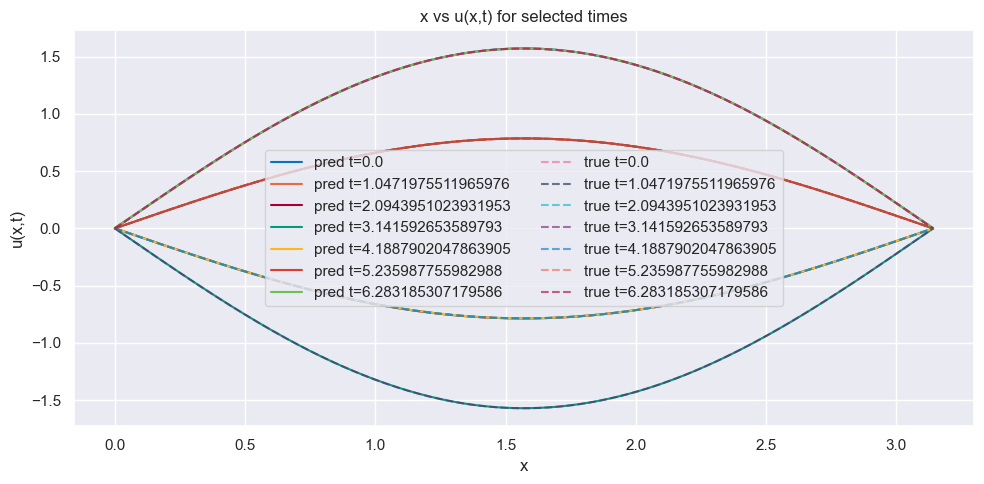

In [24]:
# Plot x vs u(x,t) for multiple time instants using the trained model

def plot_x_vs_u_at_times(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            '''
            # Model now outputs two values (u, theta), so take the first for u
            u_pred_output, _ = model(torch.cat([x, t], dim=1)).split(1, dim=-1)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output.squeeze().cpu()))
            '''
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            u_pred_output_norm, _ = model(torch.cat([x_norm, t_norm], dim=1)).split(1, dim=-1)
            u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, u_cpu in curves:
        plt.plot(x_cpu.numpy(), u_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if u(x,t) is defined above
    if with_exact and 'u_exact' in globals(): # Changed 'u' to 'u_exact' for clarity
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            u_true = u_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), u_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('x vs u(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Calculate the new time points: 0, T_end, and 5 evenly spaced times in between
num_times = 7 # 0, t_end, and 5 in between
new_times = np.linspace(0, t_end, num_times)

# Run the plot for default times
plot_x_vs_u_at_times(pinn, times=new_times, Nx =300, L_val=L, with_exact=True)

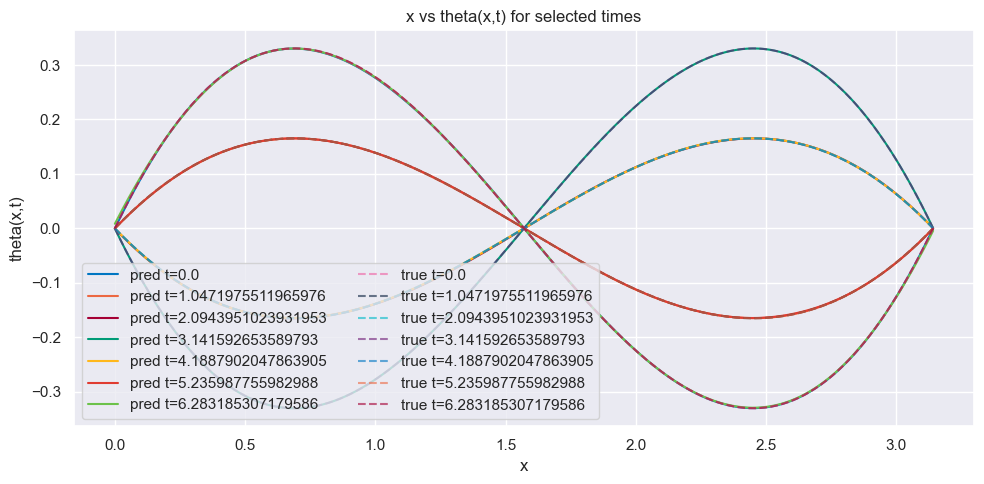

In [25]:
# Plot x vs theta(x,t) for multiple time instants using the trained model

def plot_x_vs_theta_at_times(model, times, Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            '''
            # Model now outputs two values (u, theta), so take the second for theta
            _, theta_pred_output = model(torch.cat([x, t], dim=1)).split(1, dim=-1)
            curves.append((t_val, x.squeeze().cpu(), theta_pred_output.squeeze().cpu()))
            '''
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            _, theta_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1)).split(1, dim=-1)
            theta_pred_output_denorm = theta_normalizer.denormalize(theta_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), theta_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, theta_cpu in curves:
        plt.plot(x_cpu.numpy(), theta_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if theta(x,t) is defined above
    if with_exact and 'theta_exact' in globals():
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            theta_true = theta_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), theta_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('theta(x,t)')
    plt.title('x vs theta(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Run the plot for theta
plot_x_vs_theta_at_times(pinn, times=new_times, Nx=300, L_val=L, with_exact=True)

In [26]:
x_array = np.linspace(0, np.pi, 10000)
t_array = np.linspace(0, 1, 10000)

'''
x_tensor = torch.tensor(x_array, dtype=torch.float32).view(-1, 1).to(device)
t_tensor = torch.tensor(t_array, dtype=torch.float32).view(-1, 1).to(device)
# Model now outputs two values (u, theta), so take the first for u
u_pred_output, _ = pinn(torch.cat([x_tensor, t_tensor], dim=1)).split(1, dim=-1)
u_pred = u_pred_output.cpu().detach().numpy()
u_exact_array = u_exact(x_tensor, t_tensor).cpu().detach().numpy()
R = np.linalg.norm(u_pred - u_exact_array) / np.linalg.norm(u_exact_array) * 100
'''

x_tensor = torch.tensor(x_array, dtype=torch.float32).view(-1, 1).to(device)
t_tensor = torch.tensor(t_array, dtype=torch.float32).view(-1, 1).to(device)
x_tensor_norm = x_normalizer.normalize(x_tensor)
t_tensor_norm = t_normalizer.normalize(t_tensor)
# Model now outputs two values (u, theta), so take the first for u
u_pred_output_norm, _ = pinn(torch.cat([x_tensor_norm, t_tensor_norm], dim=1)).split(1, dim=-1)
u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)
u_pred = u_pred_output_denorm.cpu().detach().numpy()
u_exact_array = u_exact(x_tensor, t_tensor).cpu().detach().numpy()
R = np.linalg.norm(u_pred - u_exact_array) / np.linalg.norm(u_exact_array) * 100

print(R)

0.04792826948687434
